# Extract features from textual data using BERT and Path signature

In [1]:
import pandas as pd
import torch
import pickle
import re

import nlpsig
from nlpsig.ffn import FeedforwardNeuralNetModel
from nlpsig.focal_loss import FocalLoss
from nlpsig.huggingface_loader import loadHF

## Load dataset

In this notebook, we use the `newspop` dataset from Huggingface and add timeline IDs and post IDs to each item. The `loadHF` class is to process this dataset.

In [2]:
# loadHF: load a dataset from hugging face
data_loader = loadHF(dataset_name="newspop", split_name="train")
data_loader.load_preprocessed_df(default_preprocess="newspop")
dataset_df = data_loader.dataset_df

[INFO] load dataframe, split: train...


Found cached dataset newspop (/Users/rchan/.cache/huggingface/datasets/newspop/default/0.0.0/9904d4082ffd3c0953efa538ff926c43d27da8f37c9b5d6a13f51ab96740474e)


  0%|          | 0/1 [00:00<?, ?it/s]

[INFO] preprocess...
[INFO] preprocessed dataframe can be accessed: .dataset_df


In [3]:
dataset_df.head()

content            datetime  \
0  Obama Lays Wreath at Arlington National Cemete... 2015-01-04 00:00:00   
1  Tim Haywood, investment director business-unit... 2015-01-01 00:00:00   
2  Nouriel Roubini, NYU professor and chairman at... 2015-01-03 00:12:00   
3  Finland's economy expanded marginally in the t... 2015-01-04 00:00:00   
4  Tourism and public spending continued to boost... 2015-01-04 00:00:00   

   label  timeline_id  post_id  
0      1            6        6  
1      2            0        2  
2      2            5        9  
3      2            6        5  
4      2            6        4

In [4]:
len(dataset_df)

93239

We use a smaller subset of the data here.

In [5]:
dataset_df = dataset_df[:2000]
dataset_df["label"].value_counts()

0    1131
2     845
1      24
Name: label, dtype: int64

In [6]:
test = nlpsig.TextEncoder(df=dataset_df,
                          col_name_text="content",
                          model_name="bert-base-uncased")

In [7]:
test.load_pretrained_model()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
test.tokenize_text()

setting return_tensors='pt'
setting return_special_tokens_mask=True
[INFO] Creating tokenized dataframe and setting in .tokenized_df attribute
'text_id' is the column name for denoting the corresponding text id


{'input_ids': tensor([[  101,  8112, 19764,  ...,     0,     0,     0],
        [  101,  5199, 10974,  ...,     0,     0,     0],
        [  101,  2053,  9496,  ...,     0,     0,     0],
        ...,
        [  101,  5533,  2011,  ...,     0,     0,     0],
        [  101,  7513,  2038,  ...,     0,     0,     0],
        [  101,  2924, 11708,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [9]:
test.tokenized_df

text_id            datetime  label  timeline_id  post_id     tokens
0            0 2015-01-04 00:00:00      1            6        6      obama
1            0 2015-01-04 00:00:00      1            6        6       lays
2            0 2015-01-04 00:00:00      1            6        6     wreath
3            0 2015-01-04 00:00:00      1            6        6         at
4            0 2015-01-04 00:00:00      1            6        6  arlington
...        ...                 ...    ...          ...      ...        ...
72857     1999 2015-01-02 00:12:00      2            3        1   argument
72858     1999 2015-01-02 00:12:00      2            3        1        for
72859     1999 2015-01-02 00:12:00      2            3        1          a
72860     1999 2015-01-02 00:12:00      2            3        1        cut
72861     1999 2015-01-02 00:12:00      2            3        1         in

[72862 rows x 6 columns]

In [147]:
tok_emb = test.obtain_embeddings(method="hidden_layer", layers=[2,3])

In [148]:
tok_emb.shape

AttributeError: 'list' object has no attribute 'shape'

In [13]:
pooled_emb = test.pool_token_embeddings(method="mean")

In [14]:
pooled_emb.shape

(2000, 768)

In [23]:
test.tokenized_df

text_id            datetime  label  timeline_id  post_id tokenized_text
0            0 2015-01-01 00:00:00      1            0        1          obama
1            0 2015-01-01 00:00:00      1            0        1           lays
2            0 2015-01-01 00:00:00      1            0        1         wreath
3            0 2015-01-01 00:00:00      1            0        1             at
4            0 2015-01-01 00:00:00      1            0        1      arlington
...        ...                 ...    ...          ...      ...            ...
72857     1999 2015-01-06 00:12:00      2           11        5       argument
72858     1999 2015-01-06 00:12:00      2           11        5            for
72859     1999 2015-01-06 00:12:00      2           11        5              a
72860     1999 2015-01-06 00:12:00      2           11        5            cut
72861     1999 2015-01-06 00:12:00      2           11        5             in

[72862 rows x 6 columns]

In [27]:
test.token_embeddings.shape

(72862, 768)

In [15]:
pooled_emb = test.pool_token_embeddings(method="mean")

TypeError: dispatcher for __array_function__ did not return an iterable

In [ ]:
pooled_emb.shape

In [21]:
import numpy as np
np.stack(test.pooled_embeddings).shape

(2000, 768)

In [14]:
test.token_embeddings[test.tokenized_df.index[test.tokenized_df[test.text_id_col_name]==0]]

array([[ 0.18321984, -0.19589207, -0.18342319, ..., -0.3154006 ,
         0.43241662,  0.5129567 ],
       [ 0.23385787,  0.03945567,  0.4769432 , ..., -0.046221  ,
        -0.08247229,  0.15072568],
       [ 0.3470364 , -0.5821233 ,  0.8347703 , ..., -0.53073364,
        -0.34710935,  1.090695  ],
       ...,
       [ 0.12746371, -0.27719072, -0.54655737, ..., -0.3627705 ,
        -0.24162048,  0.08727419],
       [-0.31046242, -0.33484203, -0.2735046 , ...,  0.2026149 ,
        -0.03832431,  0.24936728],
       [-0.4372147 ,  0.37487635,  0.553484  , ..., -0.0030742 ,
         0.05886991, -0.11947176]], dtype=float32)

In [18]:
test.token_embeddings[test.tokenized_df.index[test.tokenized_df[test.text_id_col_name]==0]].max(axis=0).shape

(768,)

In [11]:
tok_emb[0].shape

torch.Size([24, 768])

In [12]:
tok_emb = test.obtain_embeddings(method="concatenate")

In [13]:
tok_emb[0].shape

torch.Size([24, 3072])

In [14]:
tok_emb = test.obtain_embeddings(method="sum")

In [15]:
tok_emb[0].shape

torch.Size([24, 768])

In [16]:
tok_emb = test.obtain_embeddings(method="mean")

In [17]:
tok_emb[0].shape

torch.Size([24, 768])

In [ ]:
token_embeddings = 

In [78]:
torch.cat(tok_emb).shape

torch.Size([72862, 768])

In [57]:
test.df

content            datetime  \
0     Obama Lays Wreath at Arlington National Cemete... 2015-01-05 00:00:00   
1     Tim Haywood, investment director business-unit... 2015-01-03 00:00:00   
2     Nouriel Roubini, NYU professor and chairman at... 2015-01-06 00:12:00   
3     Finland's economy expanded marginally in the t... 2015-01-01 00:00:00   
4     Tourism and public spending continued to boost... 2015-01-04 00:00:00   
...                                                 ...                 ...   
1995  Over time, resilient rural producers help form... 2015-01-06 00:00:00   
1996  So Jealous reminds Democratic candidates in 20... 2015-01-06 00:12:00   
1997  Driven by surging manufacturing across North A... 2015-01-03 00:12:00   
1998  Microsoft has started to roll out the first ma... 2015-01-01 00:12:00   
1999  Bank Economist: UK Economy 'Losing Speed'. And... 2015-01-03 00:12:00   

      label  timeline_id  post_id  \
0         1            8        3   
1         2            4        7   
2         2           11        9   
3         2            0        6   
4         2            6        0   
...     ...          ...      ...   
1995      2           10        4   
1996      2           11        0   
1997      2            5        3   
1998      0            1        5   
1999      2            5        9   

                                         tokenized_text  \
0     [obama, lays, wreath, at, arlington, national,...   
1     [tim, hay, ##wood, ,, investment, director, bu...   
2     [no, ##uri, ##el, ro, ##ub, ##ini, ,, nyu, pro...   
3     [finland, ', s, economy, expanded, marginal, #...   
4     [tourism, and, public, spending, continued, to...   
...                                                 ...   
1995  [over, time, ,, res, ##ili, ##ent, rural, prod...   
1996  [so, jealous, reminds, democratic, candidates,...   
1997  [driven, by, sur, ##ging, manufacturing, acros...   
1998  [microsoft, has, started, to, roll, out, the, ...   
1999  [bank, economist, :, uk, economy, ', losing, s...   

                     tokenized_text_with_special_tokens  
0     [[CLS], obama, lays, wreath, at, arlington, na...  
1     [[CLS], tim, hay, ##wood, ,, investment, direc...  
2     [[CLS], no, ##uri, ##el, ro, ##ub, ##ini, ,, n...  
3     [[CLS], finland, ', s, economy, expanded, marg...  
4     [[CLS], tourism, and, public, spending, contin...  
...                                                 ...  
1995  [[CLS], over, time, ,, res, ##ili, ##ent, rura...  
1996  [[CLS], so, jealous, reminds, democratic, cand...  
1997  [[CLS], driven, by, sur, ##ging, manufacturing...  
1998  [[CLS], microsoft, has, started, to, roll, out...  
1999  [[CLS], bank, economist, :, uk, economy, ', lo...  

[2000 rows x 7 columns]

In [54]:
new_df = test.df.explode("tokenized_text")
new_df["text_id"] = new_df.index
new_df = new_df.reset_index()
new_df

index                                            content  \
0          0  Obama Lays Wreath at Arlington National Cemete...   
1          0  Obama Lays Wreath at Arlington National Cemete...   
2          0  Obama Lays Wreath at Arlington National Cemete...   
3          0  Obama Lays Wreath at Arlington National Cemete...   
4          0  Obama Lays Wreath at Arlington National Cemete...   
...      ...                                                ...   
72857   1999  Bank Economist: UK Economy 'Losing Speed'. And...   
72858   1999  Bank Economist: UK Economy 'Losing Speed'. And...   
72859   1999  Bank Economist: UK Economy 'Losing Speed'. And...   
72860   1999  Bank Economist: UK Economy 'Losing Speed'. And...   
72861   1999  Bank Economist: UK Economy 'Losing Speed'. And...   

                 datetime  label  timeline_id  post_id tokenized_text  \
0     2015-01-05 00:00:00      1            8        3          obama   
1     2015-01-05 00:00:00      1            8        3           lays   
2     2015-01-05 00:00:00      1            8        3         wreath   
3     2015-01-05 00:00:00      1            8        3             at   
4     2015-01-05 00:00:00      1            8        3      arlington   
...                   ...    ...          ...      ...            ...   
72857 2015-01-03 00:12:00      2            5        9       argument   
72858 2015-01-03 00:12:00      2            5        9            for   
72859 2015-01-03 00:12:00      2            5        9              a   
72860 2015-01-03 00:12:00      2            5        9            cut   
72861 2015-01-03 00:12:00      2            5        9             in   

                      tokenized_text_with_special_tokens  text_id  
0      [[CLS], obama, lays, wreath, at, arlington, na...        0  
1      [[CLS], obama, lays, wreath, at, arlington, na...        0  
2      [[CLS], obama, lays, wreath, at, arlington, na...        0  
3      [[CLS], obama, lays, wreath, at, arlington, na...        0  
4      [[CLS], obama, lays, wreath, at, arlington, na...        0  
...                                                  ...      ...  
72857  [[CLS], bank, economist, :, uk, economy, ', lo...     1999  
72858  [[CLS], bank, economist, :, uk, economy, ', lo...     1999  
72859  [[CLS], bank, economist, :, uk, economy, ', lo...     1999  
72860  [[CLS], bank, economist, :, uk, economy, ', lo...     1999  
72861  [[CLS], bank, economist, :, uk, economy, ', lo...     1999  

[72862 rows x 9 columns]

In [100]:
torch.stack([torch.cat(tok_emb)[new_df.index[new_df["text_id"]==i]].mean(dim=0) for i in range(0,2)])

tensor([[ 0.0903, -0.0068,  0.2713,  ..., -0.3028, -0.1683,  0.4341],
        [-0.2363, -0.1928,  0.0627,  ..., -0.0650,  0.1079,  0.0375]])

In [102]:
np.stack([torch.cat(tok_emb)[new_df.index[new_df["text_id"]==i]].mean(dim=0) for i in range(0,2)])

array([[ 0.09034524, -0.00681683,  0.27127367, ..., -0.3027857 ,
        -0.1682999 ,  0.43412146],
       [-0.23633283, -0.19278382,  0.06268159, ..., -0.0649549 ,
         0.10793638,  0.03745692]], dtype=float32)

In [72]:
new_df = test.df.drop(columns=["content", "tokenized_text_with_special_tokens"], errors="ignore").explode("tokenized_text")
new_df = new_df.reset_index()
new_df = new_df.rename(columns={"index": "text_id"})
new_df

text_id            datetime  label  timeline_id  post_id tokenized_text
0            0 2015-01-05 00:00:00      1            8        3          obama
1            0 2015-01-05 00:00:00      1            8        3           lays
2            0 2015-01-05 00:00:00      1            8        3         wreath
3            0 2015-01-05 00:00:00      1            8        3             at
4            0 2015-01-05 00:00:00      1            8        3      arlington
...        ...                 ...    ...          ...      ...            ...
72857     1999 2015-01-03 00:12:00      2            5        9       argument
72858     1999 2015-01-03 00:12:00      2            5        9            for
72859     1999 2015-01-03 00:12:00      2            5        9              a
72860     1999 2015-01-03 00:12:00      2            5        9            cut
72861     1999 2015-01-03 00:12:00      2            5        9             in

[72862 rows x 6 columns]

In [55]:
new_df = test.df.drop(columns=["content", "tokenized_text_with_special_tokens"]).explode("tokenized_text")
new_df.reset_index()
# new_df.rename(columns={"index": "text_id"})
new_df

datetime  label  timeline_id  post_id tokenized_text
0    2015-01-05 00:00:00      1            8        3          obama
0    2015-01-05 00:00:00      1            8        3           lays
0    2015-01-05 00:00:00      1            8        3         wreath
0    2015-01-05 00:00:00      1            8        3             at
0    2015-01-05 00:00:00      1            8        3      arlington
...                  ...    ...          ...      ...            ...
1999 2015-01-03 00:12:00      2            5        9       argument
1999 2015-01-03 00:12:00      2            5        9            for
1999 2015-01-03 00:12:00      2            5        9              a
1999 2015-01-03 00:12:00      2            5        9            cut
1999 2015-01-03 00:12:00      2            5        9             in

[72862 rows x 5 columns]

In [35]:
reduction = nlpsig.DimReduce(method = model_specifics["dim_reduction"]['method'], 
                             n_components = model_specifics["dim_reduction"]['num_components'])
embeddings_reduced = reduction.fit_transform(torch.cat(tok_emb))


In [37]:
type(embeddings_reduced)

numpy.ndarray

In [19]:
test.df["token_embeddings"][2].shape

torch.Size([30, 768])

In [22]:
len(test.df["tokenized_text_with_special_tokens"][2])

121

In [24]:
tok_emb[0].shape

torch.Size([24, 768])

In [35]:
type(test.df["token_embeddings"])

pandas.core.series.Series

In [12]:
test.tokens

{'input_ids': tensor([[  101,  8112, 19764,  ...,     0,     0,     0],
        [  101,  5199, 10974,  ...,     0,     0,     0],
        [  101,  2053,  9496,  ...,     0,     0,     0],
        ...,
        [  101,  5533,  2011,  ...,     0,     0,     0],
        [  101,  7513,  2038,  ...,     0,     0,     0],
        [  101,  2924, 11708,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'special_tokens_mask': tensor([[1, 0, 0,  ..., 1, 1, 1],
        [1, 0, 0,  ..., 1, 1, 1],
        [1, 0, 0,  ..., 1, 1, 1],
        ...,
        [1,

In [134]:
from datasets.arrow_dataset import Dataset
raw_dataset = Dataset.from_pandas(dataset_df)

In [136]:
raw_dataset["tokens"]

[['obama',
  'lays',
  'wreath',
  'at',
  'arlington',
  'national',
  'cemetery',
  '.',
  'president',
  'barack',
  'obama',
  'has',
  'laid',
  'a',
  'wreath',
  'at',
  'the',
  'tomb',
  'of',
  'the',
  'unknown',
  '##s',
  'to',
  'honor'],
 ['tim',
  'hay',
  '##wood',
  ',',
  'investment',
  'director',
  'business',
  '-',
  'unit',
  'head',
  'for',
  'fixed',
  'income',
  'at',
  'ga',
  '##m',
  ',',
  'discusses',
  'the',
  'china',
  'beige',
  'book',
  'and',
  'the',
  'state',
  'of',
  'the',
  'economy',
  '.'],
 ['no',
  '##uri',
  '##el',
  'ro',
  '##ub',
  '##ini',
  ',',
  'nyu',
  'professor',
  'and',
  'chairman',
  'at',
  'ro',
  '##ub',
  '##ini',
  'global',
  'economics',
  ',',
  'explains',
  'why',
  'the',
  'global',
  'economy',
  'isn',
  "'",
  't',
  'facing',
  'the',
  'same',
  'conditions'],
 ['finland',
  "'",
  's',
  'economy',
  'expanded',
  'marginal',
  '##ly',
  'in',
  'the',
  'three',
  'months',
  'ended',
  'december'

In [35]:
def tokenize_function(example):
    return test.tokenizer(example["content"], 
                          return_special_tokens_mask=True, 
                          return_tensors="pt",
                          truncation=True)

In [119]:
tokenized_datasets = raw_dataset.map(tokenize_function, batched = True)

  0%|          | 0/2 [00:00<?, ?ba/s]

In [120]:
tokens = tokenized_datasets.remove_columns(raw_dataset.features.keys())

KeyError: "Column all_tokens not in the dataset. Current columns in the dataset: ['input_ids', 'token_type_ids', 'attention_mask', 'special_tokens_mask']"

In [121]:
from transformers import AutoModel, AutoTokenizer, AutoConfig
from transformers import DataCollatorWithPadding

checkpoint = "bert-base-uncased"
model = AutoModel.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [103]:
tokenized_datasets.set_format("torch")

In [133]:
tokens["input_ids"][1]

31

In [123]:
tokenized_datasets

Dataset({
    features: ['content', 'datetime', 'label', 'timeline_id', 'post_id', 'tokens', 'all_tokens', 'input_ids', 'token_type_ids', 'attention_mask', 'special_tokens_mask'],
    num_rows: 2000
})

In [122]:
tokens.features

{'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'special_tokens_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [105]:
data_collator(tokenized_datasets)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


AttributeError: 'Dataset' object has no attribute 'keys'

In [137]:
tokens = tokens.remove_columns("special_tokens_mask")

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'special_tokens_mask'],
    num_rows: 2000
})

In [106]:
from torch.utils.data import DataLoader
testing = DataLoader(
    tokenized_datasets, 
    shuffle=True, 
    batch_size=8, 
    collate_fn=data_collator
)

In [107]:
for batch in testing:
    break

In [146]:
type(test.token_embeddings)

list

In [140]:
t1["input_ids"].shape

torch.Size([8, 98])

In [139]:
t1["special_tokens_mask"].shape

torch.Size([8, 98])

In [116]:
t1 = next(iter(testing))
t1["input_ids"].shape

torch.Size([8, 98])

In [117]:
hidden = model(**t1, output_hidden_states=True)

TypeError: forward() got an unexpected keyword argument 'special_tokens_mask'

In [118]:
t1

{'input_ids': tensor([[  101,  2096,  2009,  1005,  1055,  2995,  1996,  4610,  2003,  3652,
          1010,  2008,  3930,  2038,  2042,  2505,  2021,  6706,  1000,  1000,
          1000,  1998,  1999,  2070,  3572,  1010,  2091, 15950, 21446,  1000,
          1000,  1000,  2005,  1057,  1012,  1055,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  7513,  2056,  9317,  2009,  2097,  2507,  2446,  6304,  1997,
          2049,  3784,  2578,  1996,  5724,  1997, 23977,  2037,  2951,  1999,
          2762,  1010, 12786, 14516,  9394,  5936, 

In [145]:
test.token_embeddings[0].shape

(2, 24, 768)

In [55]:
test.tokenized_df[test.tokenized_df[""]==2]

text_id            datetime  label  timeline_id  post_id      tokens
53        2 2015-01-03 00:12:00      2            5        9          no
54        2 2015-01-03 00:12:00      2            5        9       ##uri
55        2 2015-01-03 00:12:00      2            5        9        ##el
56        2 2015-01-03 00:12:00      2            5        9          ro
57        2 2015-01-03 00:12:00      2            5        9        ##ub
58        2 2015-01-03 00:12:00      2            5        9       ##ini
59        2 2015-01-03 00:12:00      2            5        9           ,
60        2 2015-01-03 00:12:00      2            5        9         nyu
61        2 2015-01-03 00:12:00      2            5        9   professor
62        2 2015-01-03 00:12:00      2            5        9         and
63        2 2015-01-03 00:12:00      2            5        9    chairman
64        2 2015-01-03 00:12:00      2            5        9          at
65        2 2015-01-03 00:12:00      2            5        9          ro
66        2 2015-01-03 00:12:00      2            5        9        ##ub
67        2 2015-01-03 00:12:00      2            5        9       ##ini
68        2 2015-01-03 00:12:00      2            5        9      global
69        2 2015-01-03 00:12:00      2            5        9   economics
70        2 2015-01-03 00:12:00      2            5        9           ,
71        2 2015-01-03 00:12:00      2            5        9    explains
72        2 2015-01-03 00:12:00      2            5        9         why
73        2 2015-01-03 00:12:00      2            5        9         the
74        2 2015-01-03 00:12:00      2            5        9      global
75        2 2015-01-03 00:12:00      2            5        9     economy
76        2 2015-01-03 00:12:00      2            5        9         isn
77        2 2015-01-03 00:12:00      2            5        9           '
78        2 2015-01-03 00:12:00      2            5        9           t
79        2 2015-01-03 00:12:00      2            5        9      facing
80        2 2015-01-03 00:12:00      2            5        9         the
81        2 2015-01-03 00:12:00      2            5        9        same
82        2 2015-01-03 00:12:00      2            5        9  conditions

In [58]:
tokenized_datasets["all_tokens"]

[['[CLS]',
  'obama',
  'lays',
  'wreath',
  'at',
  'arlington',
  'national',
  'cemetery',
  '.',
  'president',
  'barack',
  'obama',
  'has',
  'laid',
  'a',
  'wreath',
  'at',
  'the',
  'tomb',
  'of',
  'the',
  'unknown',
  '##s',
  'to',
  'honor',
  '[SEP]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',


In [46]:
tokenized_datasets.remove_columns("special_tokens_mask")

Dataset({
    features: ['content', 'datetime', 'label', 'timeline_id', 'post_id', 'tokens', 'all_tokens', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2000
})

In [38]:
pd.DataFrame(tokenized_datasets)

content            datetime  \
0     Obama Lays Wreath at Arlington National Cemete... 2015-01-04 00:00:00   
1     Tim Haywood, investment director business-unit... 2015-01-01 00:00:00   
2     Nouriel Roubini, NYU professor and chairman at... 2015-01-03 00:12:00   
3     Finland's economy expanded marginally in the t... 2015-01-04 00:00:00   
4     Tourism and public spending continued to boost... 2015-01-04 00:00:00   
...                                                 ...                 ...   
1995  Over time, resilient rural producers help form... 2015-01-01 00:00:00   
1996  So Jealous reminds Democratic candidates in 20... 2015-01-06 00:12:00   
1997  Driven by surging manufacturing across North A... 2015-01-02 00:12:00   
1998  Microsoft has started to roll out the first ma... 2015-01-06 00:00:00   
1999  Bank Economist: UK Economy 'Losing Speed'. And... 2015-01-02 00:12:00   

      label  timeline_id  post_id  \
0         1            6        6   
1         2            0        2   
2         2            5        9   
3         2            6        5   
4         2            6        4   
...     ...          ...      ...   
1995      2            0        0   
1996      2           11        6   
1997      2            3        4   
1998      0           10        1   
1999      2            3        1   

                                                 tokens  \
0     [obama, lays, wreath, at, arlington, national,...   
1     [tim, hay, ##wood, ,, investment, director, bu...   
2     [no, ##uri, ##el, ro, ##ub, ##ini, ,, nyu, pro...   
3     [finland, ', s, economy, expanded, marginal, #...   
4     [tourism, and, public, spending, continued, to...   
...                                                 ...   
1995  [over, time, ,, res, ##ili, ##ent, rural, prod...   
1996  [so, jealous, reminds, democratic, candidates,...   
1997  [driven, by, sur, ##ging, manufacturing, acros...   
1998  [microsoft, has, started, to, roll, out, the, ...   
1999  [bank, economist, :, uk, economy, ', losing, s...   

                                             all_tokens  \
0     [[CLS], obama, lays, wreath, at, arlington, na...   
1     [[CLS], tim, hay, ##wood, ,, investment, direc...   
2     [[CLS], no, ##uri, ##el, ro, ##ub, ##ini, ,, n...   
3     [[CLS], finland, ', s, economy, expanded, marg...   
4     [[CLS], tourism, and, public, spending, contin...   
...                                                 ...   
1995  [[CLS], over, time, ,, res, ##ili, ##ent, rura...   
1996  [[CLS], so, jealous, reminds, democratic, cand...   
1997  [[CLS], driven, by, sur, ##ging, manufacturing...   
1998  [[CLS], microsoft, has, started, to, roll, out...   
1999  [[CLS], bank, economist, :, uk, economy, ', lo...   

                                              input_ids  \
0     [101, 8112, 19764, 29586, 2012, 13929, 2120, 4...   
1     [101, 5199, 10974, 3702, 1010, 5211, 2472, 244...   
2     [101, 2053, 9496, 2884, 20996, 12083, 5498, 10...   
3     [101, 6435, 1005, 1055, 4610, 4423, 14785, 213...   
4     [101, 6813, 1998, 2270, 5938, 2506, 2000, 1299...   
...                                                 ...   
1995  [101, 2058, 2051, 1010, 24501, 18622, 4765, 35...   
1996  [101, 2061, 9981, 15537, 3537, 5347, 1999, 235...   
1997  [101, 5533, 2011, 7505, 4726, 5814, 2408, 2167...   
1998  [101, 7513, 2038, 2318, 2000, 4897, 2041, 1996...   
1999  [101, 2924, 11708, 1024, 2866, 4610, 1005, 397...   

                                         token_type_ids  \
0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
...                                                 ...   
1995  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1996  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [ ]:
from transformers import AutoTokenizer, DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [ ]:
tokenizer_args = {"padding": True, "truncation": True, ""}
test.tokenizer(
            test.df[test.col_name_text].to_list(), **tokenizer_args
        )

In [11]:
test.df[test.col_name_text].to_list()

['Obama Lays Wreath at Arlington National Cemetery. President Barack Obama has laid a wreath at the Tomb of the Unknowns to honor',
 'Tim Haywood, investment director business-unit head for fixed income at Gam, discusses the China beige book and the state of the economy.',
 "Nouriel Roubini, NYU professor and chairman at Roubini Global Economics, explains why the global economy isn't facing the same conditions",
 "Finland's economy expanded marginally in the three months ended December, after contracting in the previous quarter, preliminary figures from Statistics Finland showed Monday. ",
 'Tourism and public spending continued to boost the economy in January, in light of contraction in private consumption and exports, according to the Bank of Thailand data. ',
 'Over 100 attendees expected to see latest version of Microsoft Dynamics SL and Dynamics GP (PRWeb February 29, 2016) Read the full story at http://www.prweb.com/releases/2016/03/prweb13238571.htm ',
 'RAMALLAH, February 25, 2

## Model specifics

Nested dictionary for models specifications.

This includes models for encoding text, path signature and etc.

In [18]:
model_specifics = {
    "encoder_args": {
        "col_name_text": "content",
        "model_name": "all-MiniLM-L6-v2", #options: all-mpnet-base-v2, all-distilroberta-v1, all-MiniLM-L12-v2
        "model_args": {
            "batch_size": 64,
            "show_progress_bar": True,
            "output_value": 'sentence_embedding', 
            "convert_to_numpy": True,
            "convert_to_tensor": False,
            "device": None,
            "normalize_embeddings": False
        }
    },
    "dim_reduction": {
        "method": 'umap', #options: ppapca, ppapcappa, umap
        "num_components": 10, # options: any int number between 1 and embedding dimensions
    },
    "embedding":{
        "global_embedding_tp": 'SBERT', #options: SBERT, BERT_cls , BERT_mean, BERT_max
        "post_embedding_tp": 'sentence', #options: sentence, reduced
        "feature_combination_method": 'attention', #options concatenation, attention 
    },
    "time_injection": {
        "history_tp": 'timestamp', #options: timestamp, None
        "post_tp": 'timestamp', #options: timestamp, timediff, None
    },
    "signature": {
        "dimensions": 3, #options: any int number larger than 1
        "method": 'log', # options: log, sig
        "interval": 1/12
    }
}

## Encode text: obtaining sentence embeddings

We can use the `TextEncoder` class within `nlpsig` to obtain sentence embeddings from a model. Here, we have defined the encoder arguments in `model_specifics`.

In [19]:
model_specifics["encoder_args"]

{'col_name_text': 'content',
 'model_name': 'all-MiniLM-L6-v2',
 'model_args': {'batch_size': 64,
  'show_progress_bar': True,
  'output_value': 'sentence_embedding',
  'convert_to_numpy': True,
  'convert_to_tensor': False,
  'device': None,
  'normalize_embeddings': False}}

We can pass these into the constructor of the class to initialise our text encoder as follows:

In [20]:
# initialise the Text Encoder 
text_encoder = nlpsig.SentenceEncoder(dataset_df,
                                  col_name_text = model_specifics["encoder_args"]["col_name_text"], 
                                  model_name = model_specifics["encoder_args"]["model_name"],
                                  model_encoder_args = model_specifics["encoder_args"]["model_args"])

We can see that these are stored as attributes in the object:

In [21]:
text_encoder.df

content            datetime  \
0     Obama Lays Wreath at Arlington National Cemete... 2015-01-05 00:00:00   
1     Tim Haywood, investment director business-unit... 2015-01-03 00:00:00   
2     Nouriel Roubini, NYU professor and chairman at... 2015-01-06 00:12:00   
3     Finland's economy expanded marginally in the t... 2015-01-01 00:00:00   
4     Tourism and public spending continued to boost... 2015-01-04 00:00:00   
...                                                 ...                 ...   
1995  Over time, resilient rural producers help form... 2015-01-06 00:00:00   
1996  So Jealous reminds Democratic candidates in 20... 2015-01-06 00:12:00   
1997  Driven by surging manufacturing across North A... 2015-01-03 00:12:00   
1998  Microsoft has started to roll out the first ma... 2015-01-01 00:12:00   
1999  Bank Economist: UK Economy 'Losing Speed'. And... 2015-01-03 00:12:00   

      label  timeline_id  post_id  \
0         1            8        3   
1         2            4        7   
2         2           11        9   
3         2            0        6   
4         2            6        0   
...     ...          ...      ...   
1995      2           10        4   
1996      2           11        0   
1997      2            5        3   
1998      0            1        5   
1999      2            5        9   

                                         tokenized_text  \
0     [obama, lays, wreath, at, arlington, national,...   
1     [tim, hay, ##wood, ,, investment, director, bu...   
2     [no, ##uri, ##el, ro, ##ub, ##ini, ,, nyu, pro...   
3     [finland, ', s, economy, expanded, marginal, #...   
4     [tourism, and, public, spending, continued, to...   
...                                                 ...   
1995  [over, time, ,, res, ##ili, ##ent, rural, prod...   
1996  [so, jealous, reminds, democratic, candidates,...   
1997  [driven, by, sur, ##ging, manufacturing, acros...   
1998  [microsoft, has, started, to, roll, out, the, ...   
1999  [bank, economist, :, uk, economy, ', losing, s...   

                     tokenized_text_with_special_tokens  
0     [[CLS], obama, lays, wreath, at, arlington, na...  
1     [[CLS], tim, hay, ##wood, ,, investment, direc...  
2     [[CLS], no, ##uri, ##el, ro, ##ub, ##ini, ,, n...  
3     [[CLS], finland, ', s, economy, expanded, marg...  
4     [[CLS], tourism, and, public, spending, contin...  
...                                                 ...  
1995  [[CLS], over, time, ,, res, ##ili, ##ent, rura...  
1996  [[CLS], so, jealous, reminds, democratic, cand...  
1997  [[CLS], driven, by, sur, ##ging, manufacturing...  
1998  [[CLS], microsoft, has, started, to, roll, out...  
1999  [[CLS], bank, economist, :, uk, economy, ', lo...  

[2000 rows x 7 columns]

In [22]:
text_encoder.col_name_text

'content'

In [23]:
text_encoder.model_name

'all-MiniLM-L6-v2'

In [24]:
text_encoder.model_encoder_args

{'batch_size': 64,
 'show_progress_bar': True,
 'output_value': 'sentence_embedding',
 'convert_to_numpy': True,
 'convert_to_tensor': False,
 'device': None,
 'normalize_embeddings': False}

There are other attributes `embeddings_sentence` and `model` which are `None` type when the class is initialised:

In [26]:
print(text_encoder.sentence_embeddings)
print(text_encoder.model)

None
None


The class has a `.encode_sentence_transformer()` method which first loads in the model (using the `model_name` and `model_args` attributes) and then obtains an embedding for each sentence. These sentence embeddings are then stored in the `embeddings_sentence` attribute of the object.

In [27]:
text_encoder.load_pretrained_model()

In [29]:
text_encoder.encode_sentence_transformer()
embeddings_sentence = text_encoder.sentence_embeddings

[INFO] number of sentences to encode: 2000


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [30]:
type(embeddings_sentence)

numpy.ndarray

In [17]:
embeddings_sentence.ndim

2

In [18]:
embeddings_sentence.shape

(2000, 384)

In [19]:
import numpy as np
np.array(torch.tensor(embeddings_sentence)).shape

(2000, 384)

In [13]:
from transformers import AutoModel, AutoTokenizer, AutoConfig
checkpoint = "bert-base-uncased"
model = AutoModel.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
content = dataset_df["content"].to_list()

In [26]:
import math
n_batches = 10
samples_per_batch = math.ceil(len(content)/n_batches)
batched_content = [content[i:i + samples_per_batch] for i in range(0, len(content), samples_per_batch)]

In [27]:
content

['Obama Lays Wreath at Arlington National Cemetery. President Barack Obama has laid a wreath at the Tomb of the Unknowns to honor',
 'Tim Haywood, investment director business-unit head for fixed income at Gam, discusses the China beige book and the state of the economy.',
 "Nouriel Roubini, NYU professor and chairman at Roubini Global Economics, explains why the global economy isn't facing the same conditions",
 "Finland's economy expanded marginally in the three months ended December, after contracting in the previous quarter, preliminary figures from Statistics Finland showed Monday. ",
 'Tourism and public spending continued to boost the economy in January, in light of contraction in private consumption and exports, according to the Bank of Thailand data. ',
 'Over 100 attendees expected to see latest version of Microsoft Dynamics SL and Dynamics GP (PRWeb February 29, 2016) Read the full story at http://www.prweb.com/releases/2016/03/prweb13238571.htm ',
 'RAMALLAH, February 25, 2

In [28]:
model_input = tokenizer(text=content,
          padding=True,
          return_tensors="pt",
          return_special_tokens_mask=True)

In [29]:
model_input["attention_mask"][0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])

In [30]:
skip_spec = True
if skip_spec:
    indices = [torch.where(model_input["special_tokens_mask"][i]==0)[0] for i in range(len(dataset_df))]
else:
    indices = [torch.where(model_input["attention_mask"][i]==1)[0] for i in range(len(dataset_df))]

In [31]:
indices[0]

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24])

In [123]:
%%time
model_input_bep = tokenizer.batch_encode_plus(content,
                        padding = True,
                        return_tensors="pt")

CPU times: user 259 ms, sys: 8.25 ms, total: 267 ms
Wall time: 71.6 ms


In [20]:
%%time
model_input = tokenizer(content,
                        padding = True,
                        return_tensors="pt",
                        return_special_tokens_mask=True)

CPU times: user 267 ms, sys: 12.4 ms, total: 279 ms
Wall time: 91.4 ms


In [24]:
type(model_input)

transformers.tokenization_utils_base.BatchEncoding

In [28]:
special_tokens_mask = model_input.data.pop("special_tokens_mask")

In [29]:
special_tokens_mask

tensor([[1, 0, 0,  ..., 1, 1, 1],
        [1, 0, 0,  ..., 1, 1, 1],
        [1, 0, 0,  ..., 1, 1, 1],
        ...,
        [1, 0, 0,  ..., 1, 1, 1],
        [1, 0, 0,  ..., 1, 1, 1],
        [1, 0, 0,  ..., 1, 1, 1]])

In [31]:
model_input

{'input_ids': tensor([[  101,  8112, 19764,  ...,     0,     0,     0],
        [  101,  5199, 10974,  ...,     0,     0,     0],
        [  101,  2053,  9496,  ...,     0,     0,     0],
        ...,
        [  101,  5533,  2011,  ...,     0,     0,     0],
        [  101,  7513,  2038,  ...,     0,     0,     0],
        [  101,  2924, 11708,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [59]:
model_input

{'input_ids': tensor([[  101,  8112, 19764,  ...,     0,     0,     0],
        [  101,  5199, 10974,  ...,     0,     0,     0],
        [  101,  2053,  9496,  ...,     0,     0,     0],
        ...,
        [  101,  5533,  2011,  ...,     0,     0,     0],
        [  101,  7513,  2038,  ...,     0,     0,     0],
        [  101,  2924, 11708,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [51]:
model_input_0 = tokenizer(content[0:10],
                        padding=True,
                        return_tensors="pt")
outputs = model(**model_input_0, output_hidden_states = True)
last_hidden_0 = outputs["last_hidden_state"]

In [54]:
outputs["hidden_states"].shape

AttributeError: 'tuple' object has no attribute 'shape'

In [254]:
last_hidden_0

tensor([[[-0.5035,  0.1192, -0.6883,  ..., -0.4821,  0.3381,  0.2473],
         [ 0.1832, -0.1959, -0.1834,  ..., -0.3154,  0.4324,  0.5130],
         [ 0.2339,  0.0395,  0.4769,  ..., -0.0462, -0.0825,  0.1507],
         ...,
         [-0.3105, -0.3348, -0.2735,  ...,  0.2026, -0.0383,  0.2494],
         [-0.4372,  0.3749,  0.5535,  ..., -0.0031,  0.0589, -0.1195],
         [ 0.6783, -0.0195, -0.2208,  ...,  0.2258, -0.5738, -0.1603]]],
       grad_fn=<NativeLayerNormBackward>)

In [92]:
last_hidden_0.shape

torch.Size([1, 26, 768])

In [133]:
model_input = tokenizer(content,
                        padding=True,
                        return_tensors="pt")
model.eval()
with torch.no_grad():
    outputs = model(**model_input, output_hidden_states=True)
    last_hidden = outputs["last_hidden_state"]

In [137]:
hidden_states = torch.stack(outputs["hidden_states"], dim=0)

In [183]:
layer = [hidden_states.shape[0]-1]

In [205]:
 [hidden_states.shape[0]-i for i in range(1, 5) if hidden_states.shape[0]-i >= 0]

[12, 11, 10, 9]

In [215]:
test = hidden_states[[12, 11, 10, 9]].permute(1,2,0,3)

In [242]:
test.shape

torch.Size([2000, 121, 4, 768])

In [247]:
torch.stack([test[0][indices[0]][j].flatten() for j in range(len(indices[0]))])

torch.Size([24, 3072])

In [258]:
test[0][indices[0]][0].mean(dim=0).shape

torch.Size([768])

In [238]:
test[0][indices[0]][0]

tensor([[ 0.1832, -0.1959, -0.1834,  ..., -0.3154,  0.4324,  0.5130],
        [ 0.6616, -0.9264, -0.0137,  ..., -1.3369, -0.3049,  0.2584],
        [ 0.5954, -1.2776,  0.4303,  ..., -1.3170, -0.1471,  0.1415],
        [ 0.4465, -1.1288,  0.2996,  ..., -0.6836, -0.4430,  0.1470]])

In [199]:
hidden_states[-1:].shape

torch.Size([4, 2000, 121, 768])

In [204]:
hidden_states[[13-4, 13-3, 13-2, 13-1]] == hidden_states[-4:]

tensor([[[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ...

In [185]:
hidden_states[layer].shape#permute(1,0,2,3)[0][:,indices[0],:].shape

torch.Size([1, 2000, 121, 768])

In [182]:
hidden_states[layer].shape

torch.Size([2000, 121, 768])

In [175]:
if test.shape[0]==1:
    test = test[0]

In [177]:
test.shape

torch.Size([24, 768])

In [ ]:
hidden_states[lay]

In [237]:
last_hidden[0][:26,:]

tensor([[-0.5035,  0.1192, -0.6883,  ..., -0.4821,  0.3381,  0.2473],
        [ 0.1832, -0.1959, -0.1834,  ..., -0.3154,  0.4324,  0.5130],
        [ 0.2339,  0.0395,  0.4769,  ..., -0.0462, -0.0825,  0.1507],
        ...,
        [-0.3105, -0.3348, -0.2735,  ...,  0.2026, -0.0383,  0.2494],
        [-0.4372,  0.3749,  0.5535,  ..., -0.0031,  0.0589, -0.1195],
        [ 0.6783, -0.0195, -0.2208,  ...,  0.2258, -0.5738, -0.1603]])

In [236]:
last_hidden[0][indices[0],:]

tensor([[ 0.1832, -0.1959, -0.1834,  ..., -0.3154,  0.4324,  0.5130],
        [ 0.2339,  0.0395,  0.4769,  ..., -0.0462, -0.0825,  0.1507],
        [ 0.3470, -0.5821,  0.8348,  ..., -0.5307, -0.3471,  1.0907],
        ...,
        [ 0.1275, -0.2772, -0.5466,  ..., -0.3628, -0.2416,  0.0873],
        [-0.3105, -0.3348, -0.2735,  ...,  0.2026, -0.0383,  0.2494],
        [-0.4372,  0.3749,  0.5535,  ..., -0.0031,  0.0589, -0.1195]])

In [108]:
last_hidden[0][26:,:]

tensor([[-0.1062,  0.1590,  0.3808,  ..., -0.2130,  0.2363,  0.3481],
        [-0.3295, -0.0325,  0.0659,  ..., -0.0008,  0.1564, -0.0858],
        [-0.3254,  0.0501,  0.3175,  ..., -0.0375,  0.1237,  0.0306],
        ...,
        [-0.5344, -0.4571, -0.0551,  ...,  0.4129,  0.7019, -0.2756],
        [-0.2344,  0.0116,  0.1516,  ...,  0.0746, -0.0130, -0.0148],
        [-0.3509, -0.2063,  0.1589,  ...,  0.1341,  0.1661, -0.1478]])

In [198]:
tokenized_text = [tokenizer.convert_ids_to_tokens(model_input["input_ids"][i], skip_special_tokens=True) for i in range(len(dataset_df))]

In [164]:
tokenizer.special_tokens_map.values()

dict_values(['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]'])

In [181]:
np.array([0,1,2]) < 5

array([ True,  True,  True])

In [184]:
np.array(tokenized_text[0])

array(['[CLS]', 'obama', 'lays', 'wreath', 'at', 'arlington', 'national',
       'cemetery', '.', 'president', 'barack', 'obama', 'has', 'laid',
       'a', 'wreath', 'at', 'the', 'tomb', 'of', 'the', 'unknown', '##s',
       'to', 'honor', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]'

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [188]:
np.where(tokenized_text[0] not in tokenizer.special_tokens_map.values(), True, False)

array(True)

In [200]:
tokenized_text[0]

['obama',
 'lays',
 'wreath',
 'at',
 'arlington',
 'national',
 'cemetery',
 '.',
 'president',
 'barack',
 'obama',
 'has',
 'laid',
 'a',
 'wreath',
 'at',
 'the',
 'tomb',
 'of',
 'the',
 'unknown',
 '##s',
 'to',
 'honor']

In [201]:
np.where(np.array([token not in tokenizer.special_tokens_map.values() for token in tokenized_text[0]]))[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [190]:
indices = np.where(np.array([token not in tokenizer.special_tokens_map.values() for token in tokenized_text[0]]))[0]

In [192]:
len(indices)

24

In [195]:
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [197]:
indices = np.where(np.array([token not in tokenizer.special_tokens_map["pad_token"] for token in tokenized_text[0]]))[0]
len(indices)

26

In [166]:
token_emb = torch.stack(outputs["hidden_states"], dim=0)

In [127]:
token_emb = token_emb.permute(1,2,0,3)

In [191]:
token_emb[0][indices].shape

torch.Size([24, 121, 768])

In [154]:
token_vecs_cat = []
for token in token_emb[0][:26]:
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    token_vecs_cat.append(cat_vec)

In [157]:
token_vecs_cat[0].shape

torch.Size([3072])

In [ ]:
[self.tokenizer.convert_ids_to_tokens(tokens["input_ids"][i]) for i in range(len(self.df))]

In [123]:
token_emb.shape

torch.Size([13, 2000, 121, 768])

In [73]:
model_input

{'input_ids': tensor([[  101,  8112, 19764, 29586,  2012, 13929,  2120,  4528,  1012,  2343,
         13857,  8112,  2038,  4201,  1037, 29586,  2012,  1996,  8136,  1997,
          1996,  4242,  2015,  2000,  3932,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]])}

In [89]:
len(tokenizer.convert_ids_to_tokens(model_input["input_ids"][0].tolist()))

26

In [72]:
hidden_states[0].shape

torch.Size([1, 26, 768])

In [88]:
hidden_states[0][0].shape

torch.Size([26, 768])

In [46]:
output = model(**model_input, output_hidden_states=True)

In [55]:
output["hidden_states"][0].shape

torch.Size([100, 98, 768])

In [49]:
model_input

{'input_ids': tensor([[  101,  8112, 19764,  ...,     0,     0,     0],
        [  101,  5199, 10974,  ...,     0,     0,     0],
        [  101,  2053,  9496,  ...,     0,     0,     0],
        ...,
        [  101,  1037,  2047,  ...,     0,     0,     0],
        [  101,  7513,  2038,  ...,     0,     0,     0],
        [  101,  7513,  2197,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [120]:
ids

[8112,
 19764,
 29586,
 2012,
 13929,
 2120,
 4528,
 1012,
 2343,
 13857,
 8112,
 2038,
 4201,
 1037,
 29586,
 2012,
 1996,
 8136,
 1997,
 1996,
 4242,
 2015,
 2000,
 3932]

In [115]:
ids = tokenizer.convert_ids_to_tokens(tokens)

ValueError: invalid literal for int() with base 10: 'obama'

AttributeError: module 'nlpsig' has no attribute 'TextEncoder'

### Obtaining embeddings from a pickle file

Note that we could also optionally pass in any pre-computed sentence embeddings (which are saved with a pickle file) if we wanted to. So in this directory, there is a file named `pre_comp_emb.pkl`, we can load these in by:

In [15]:
text_encoder = nlpsig.TextEncoder(df = dataset_df,
                                  pre_computed_embeddings_file = "pre_comp_emb.pkl")

In [16]:
text_encoder.embeddings_sentence

array([[ 0.04053079,  0.12677227,  0.03034634, ...,  0.01346129,
         0.00509907, -0.02261563],
       [ 0.00132176, -0.0018716 ,  0.04704979, ..., -0.12755243,
        -0.00235985, -0.01032072],
       [-0.00446173, -0.07742908, -0.02367788, ..., -0.12149315,
        -0.02713374, -0.01476178],
       ...,
       [ 0.11392148, -0.08496089,  0.04116976, ..., -0.06292846,
        -0.01069093,  0.05599773],
       [-0.00467583,  0.03044874,  0.0136638 , ...,  0.01504119,
         0.07309043,  0.05808413],
       [ 0.00844448, -0.04087541,  0.0106803 , ..., -0.02920137,
         0.03407754,  0.04248996]], dtype=float32)

As we passed in a pickle file, `model_name`, `model_args`, and `model` are given default values to highlight this:

In [17]:
print("model_name: " + text_encoder.model_name)
print("model_args: " + str(text_encoder.model_args))
print("model: " + text_encoder.model)

model_name: pre-computed
model_args: None
model: pre-computed


## Plotting the embeddings with dimensionality reduction

There is a `PlotEmbedding` class within `nlpsig` which can produce two-dimensional plots of the embeddings by first performing a dimensionality reduction. We will do this here using `UMAP`:

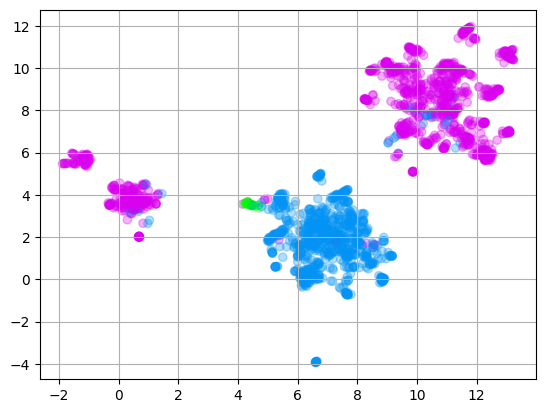

In [18]:
plt_embed = nlpsig.PlotEmbedding(x_data = embeddings_sentence,
                                 y_data = dataset_df["label"].values)

plt_embed.plt_2d(
    embed_args = {
        "method": "umap",
        "dim": 2
    }
)

## Dimensionality reduction

While the `PlotEmbedding` class allows us to visualise the embeddings, the `DimReduce` is more specific to reducing the dimensionality of the embedding space to be used later on (rather than just focus on using it for plotting). We can initialise the object by passing in what method we want to use, choosing out of:

* pca
* umap
* tsne
* ppapca
* ppapcappa

Here we specified our choices in `model_specifics` above:

In [19]:
model_specifics["dim_reduction"]

{'method': 'umap', 'num_components': 10}

The `.fit_transform()` method performs the dimensionality reduction and returns the reduced vectors (they also save them into the `embedding` attribute of the object.

In [21]:
reduction = nlpsig.DimReduce(method = model_specifics["dim_reduction"]['method'], 
                             n_components = model_specifics["dim_reduction"]['num_components'])
embeddings_reduced = reduction.fit_transform(embeddings_sentence)

In [22]:
print(embeddings_sentence.shape)
print(embeddings_reduced.shape)

(2000, 384)
(2000, 10)


We can again visualise these using the `PlotEmbedding` class.

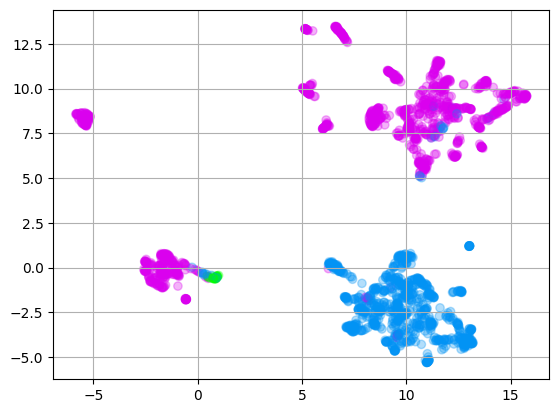

In [23]:
plt_embed = nlpsig.PlotEmbedding(x_data = embeddings_reduced,
                                 y_data = dataset_df["label"].values)

plt_embed.plt_2d(
    embed_args = {
        "method": "umap",
        "dim": 2
    }
)

## Data preparation: Time injection and Padding

In [24]:
len(dataset_df)

2000

In [25]:
embeddings_sentence.shape

(2000, 384)

In [26]:
embeddings_reduced.shape

(2000, 10)

Note to Talia: the `PrepareData` class now has all the `TimeInjection` and `Padding` methods and `get_modelling_df()` (so I've just combined these all together as they're all related to preparing the dataset into the correct form for later).

To use `PrepareData` class, you pass in the dataframe containing the data, the sentence embeddings, and optionally the dimension reduced sentence embeddings:

In [37]:
import re
from typing import List, Optional, Tuple, Union

import numpy as np
import pandas as pd
import torch


class PrepareData:
    """
    Class to prepare dataset for computing signatures
    """

    def __init__(
        self,
        dataset_df: pd.DataFrame,
        embeddings: np.array,
        embeddings_reduced: Optional[np.array] = None,
        id_column: Optional[str] = None,
        labels_column: Optional[str] = None,
    ):
        """
        Class to prepare dataset for computing signatures

        Parameters
        ----------
        dataset_df : pd.DataFrame
            Dataset as a pandas dataframe
        embeddings : np.array
            Embeddings for each of the items in dataset_df
        embeddings_reduced : Optional[np.array], optional
            Dimension reduced embeddings, by default None
        id_column : Optional[str]
            Name of the column which identifies each of the text, e.g.
            - "text_id" (if each item in dataset_df is a word or sentence from a particular text),
            - "user_id" (if each item in dataset_df is a post from a particular user)
            - "timeline_id" (if each item in dataset_df is a post from a particular time)
            If None, it will create a dummy id_column named "dummy_id" and fill with zeros
        labels_column : Optional[str]
            Name of the column which are corresponds to the labels of the data

        Raises
        ------
        ValueError
            if dataset_df and embeddings does not have the same number of rows
        ValueError
            if dataset_df and embeddings_reduced does not have the same number of rows
            (if embeddings_reduced is provided)
        """
        # perform checks that dataset_df have the right column names to work with
        if dataset_df.shape[0] != embeddings.shape[0]:
            raise ValueError(
                "dataset_df, embeddings and embeddings_reduced "
                + "should have the same number of rows"
            )
        if embeddings_reduced is not None:
            if dataset_df.shape[0] != embeddings_reduced.shape[0]:
                raise ValueError(
                    "dataset_df, embeddings and embeddings_reduced "
                    + "should have the same number of rows"
                )
        self.dataset_df = dataset_df
        self.id_column = id_column
        self.label_column = labels_column
        self.embeddings = embeddings
        self.embeddings_reduced = embeddings_reduced
        # obtain modelling dataframe
        self.df = None
        self.df = self._get_modeling_dataframe()
        # obtain time features
        self._time_feature_choices = []
        self.time_features_added = False
        self.df = self._set_time_features()
        self.df_padded = None
        self.array_padded = None

    def _get_modeling_dataframe(self) -> pd.DataFrame:
        """
        [Private] Combines original dataset_df with the sentence
        embeddings and the dimension reduced embeddings

        Returns
        -------
        pd.DataFrame
            Original dataframe concatenated with the embeddings and
            dimension reduced embeddings (column-wise)
            - columns starting with "e" followed by a number denotes each
              dimension of the embeddings
            - columns starting with "d" followed by a number denotes each
              dimension of the dimension reduced embeddings
        """
        if self.df is not None:
            return self.df
        else:
            embedding_df = pd.DataFrame(
                self.embeddings,
                columns=[f"e{i+1}" for i in range(self.embeddings.shape[1])],
            )
            if self.embeddings_reduced is not None:
                embeddings_reduced_df = pd.DataFrame(
                    self.embeddings_reduced,
                    columns=[
                        f"d{i+1}" for i in range(self.embeddings_reduced.shape[1])
                    ],
                )
                df = pd.concat(
                    [
                        self.dataset_df.reset_index(drop=True),
                        embeddings_reduced_df,
                        embedding_df,
                    ],
                    axis=1,
                )
            else:
                df = pd.concat(
                    [self.dataset_df.reset_index(drop=True), embedding_df],
                    axis=1,
                )
            if self.id_column is None:
                self.id_column = "dummy_id"
                print(
                    f"[INFO] No id_column was passed, so setting id_column to '{self.id_column}'"
                )
            if self.id_column not in self.dataset_df.columns:
                # set default value to id_column
                print(
                    f"[INFO] There is no column in .dataset_df called '{self.id_column}'. "
                    + "Adding a new column named '{self.id_column}' of zeros"
                )
                df[self.id_column] = 0
            return df

    @staticmethod
    def _time_fraction(x: pd.Timestamp) -> float:
        """
        [Private] Converts a date, x, as a fraction of the year.

        Parameters
        ----------
        x : pd.Timestamp
            Date

        Returns
        -------
        float
            The date as a fraction of the year
        """
        # compute how many seconds the date is into the year
        x_year_start = pd.Timestamp(x.year, 1, 1)
        seconds_into_cal_year = abs(x - x_year_start).total_seconds()
        # compute the time fraction into the year
        time_frac = seconds_into_cal_year / (365 * 24 * 60 * 60)
        return x.year + time_frac

    def _set_time_features(self) -> pd.DataFrame:
        """
        [Private] Updates the dataframe in .df to include time features:
        - `time_encoding`: the date as a fraction of the year
           (only if 'datetime' is a column in .df dataframe)
        - `time_diff`: the difference in time (in minutes) between successive records
           (only if 'datetime' is a column in .df dataframe)
        - `timeline_index`: the index of each post for each id

        Returns
        -------
        pd.DataFrame
            Updated dataframe with time features
        """
        if self.time_features_added:
            print("Time features have already been added")
            return
        print("[INFO] Adding time feature columns into dataframe in .df")
        if "datetime" in self.df.columns:
            # obtain time encoding by computing the fraction of year it is in
            self._time_feature_choices += ["time_encoding", "time_diff"]
            self.df["time_encoding"] = self.df["datetime"].map(
                lambda t: self._time_fraction(t)
            )
            # sort by the id and the date
            self.df = self.df.sort_values(by=[self.id_column, "datetime"]).reset_index(
                drop=True
            )
            # calculate time difference between posts
            self.df["time_diff"] = 0
            for i in range(1, len(self.df)):
                if self.id_column == "timeline_id":
                    condition = self.df[self.id_column].iloc[i] != self.df[self.id_column].iloc[i - 1]
                else:
                    condition = self.df[self.id_column].iloc[i] == self.df[self.id_column].iloc[i - 1]
                if condition:
                    diff = self.df["datetime"].iloc[i] - self.df["datetime"].iloc[i - 1]
                    diff_in_mins = diff.total_seconds() / 60
                    self.df.loc[i, "time_diff"] = diff_in_mins
        else:
            print(
                "[INFO] datetime is not a column in .df, "
                + "so only 'timeline_index' is added"
            )
            print(
                "[INFO] as datetime is not a column in .df, "
                + "we assume that the data is ordered by time with respect to the id"
            )
        # assign index for each post in each timeline
        self._time_feature_choices += ["timeline_index"]
        self.df["timeline_index"] = 0
        first_index = 0
        for id in sorted(list(set(self.df[self.id_column]))):
            # obtain the indices for this id
            id_len = sum(self.df[self.id_column] == id)
            last_index = first_index + id_len - 1
            # assign indices for each post in this id from 1 to id_len
            self.df.loc[first_index:last_index, "timeline_index"] = list(
                range(1, id_len + 1)
            )
            first_index = last_index + 1
        self.time_features_added = True

        return self.df

    def _obtain_colnames(self, embeddings: str) -> List[str]:
        """
        [Private] Obtains the column names storing the embeddings.

        Parameters
        ----------
        embeddings : str
            Options are:
            - "dim_reduced": dimension reduced embeddings
            - "full": full embeddings
            - "both": concatenation of dimension reduced and full embeddings

        Returns
        -------
        List[str]
            List of column names which store the embeddings

        Raises
        ------
        ValueError
            if embeddings is not either of 'dim_reduced', 'full', or 'both'
        """
        if embeddings not in ["dim_reduced", "full", "both"]:
            raise ValueError(
                "embeddings must be either 'dim_reduced', 'full', or 'both'"
            )
        if embeddings == "dim_reduced":
            # obtain columns for the dimension reduced embeddings
            # these are columns which start with 'd' and have a number following it
            colnames = [col for col in self.df.columns if re.match(r"^d\w*[0-9]", col)]
        elif embeddings == "full":
            # obtain columns for the full embeddings
            # these are columns which start with 'e' and have a number following it
            colnames = [col for col in self.df.columns if re.match(r"^e\w*[0-9]", col)]
        elif embeddings == "both":
            # add columns for the embeddings
            colnames = [col for col in self.df.columns if re.match(r"^d\w*[0-9]", col)]
            colnames += [col for col in self.df.columns if re.match(r"^e\w*[0-9]", col)]
        return colnames

    def _obtain_time_feature_columns(
        self,
        time_feature: Optional[Union[List[str], str]],
    ) -> List[str]:
        """
        [Private] Obtains the column names storing the time features requested.

        Parameters
        ----------
        time_feature : Optional[Union[List[str], str]]
            If is a string, it must be the list found in
            `_time_feature_choices` attribute. If is a list,
            each item must be a string and it must be in the
            list found in `_time_feature_choices` attribute

        Returns
        -------
        List[str]
            List of column names which store the time features

        Raises
        ------
        ValueError
            if `time_feature` is a string, and it is not found in `_time_feature_choices`
        ValueError
            if `time_feature` is a list of strings, and one of the items
            is not found in `_time_feature_choices`
        """
        if time_feature is None:
            time_feature = []
        else:
            if not self.time_features_added:
                self.set_time_features()
            if isinstance(time_feature, str):
                if time_feature not in self._time_feature_choices:
                    raise ValueError(
                        "If time_feature is a string, it must "
                        + f"be in {self._time_feature_choices}"
                    )
                else:
                    time_feature = [time_feature]
            elif isinstance(time_feature, list):
                if not all(
                    [item in self._time_feature_choices for item in time_feature]
                ):
                    raise ValueError(
                        f"Each item in time_feature should be in {self._time_feature_choices}"
                    )
            else:
                raise ValueError(
                    "time_feature must be either None, a string, or a list of strings"
                )
        return time_feature

    def _pad_id(
        self,
        k: int,
        zero_padding: bool,
        colnames: List[str],
        id_counts: pd.Series,
        id: int,
        time_feature: List[str],
    ) -> pd.DataFrame:
        """
        [Private] For a given id, the function slices the dataframe in .df
        by finding those with id_column == id and keeping only the columns
        found in colnames.
        The function returns a dataframe with k rows:
        - If the number of records with id_column == id is less than k, it "pads" the
        dataframe by adding in empty records (with label = -1 to indicate they're padded)
        - If the number of records with id_column == id is equal to k, it just returns
        the records with id_column == id

        Parameters
        ----------
        k : int
            Number of items to keep
        zero_padding : bool
            If True, will pad with zeros. Otherwise, pad with the latest
            text associated to the id
        colnames : List[str]
            List of column names that we wish to keep from the dataframe
        id_counts : pd.Series
            The number of records in associated to each id_column
        id : int
            Which id are we padding
        time_feature : List[str]
            List of time feature column names that we wish to keep from the dataframe

        Returns
        -------
        pd.DataFrame
            Padded dataframe for a particular id

        Raises
        ------
        ValueError
            if k is not a positive integer
        """
        if k < 0:
            raise ValueError("k must be a positive integer")
        padding_n = k - id_counts[id]
        columns = [self.id_column] + time_feature + colnames
        if self.label_column is not None:
            columns += [self.label_column]
        if padding_n > 0:
            # need to pad to fill up
            if zero_padding:
                # pad by having zero entries
                if self.label_column is not None:
                    data_dict = {
                        **{self.id_column: [id], self.label_column: [-1]},
                        **dict.fromkeys(time_feature, [0]),
                        **{c: [0] for c in colnames},
                    }
                else:
                    data_dict = {
                        **{self.id_column: [id]},
                        **dict.fromkeys(time_feature, [0]),
                        **{c: [0] for c in colnames},
                    }
                df_padded = pd.concat(
                    [
                        pd.concat([pd.DataFrame(data_dict)] * padding_n),
                        self.df[self.df[self.id_column] == id][columns],
                    ]
                )
            else:
                # pad by repeating the latest text
                latest_text = self.df[self.df[self.id_column] == id][columns].tail(1)
                df_padded = pd.concat(
                    [
                        self.df[self.df[self.id_column] == id][columns],
                        pd.concat([latest_text] * padding_n),
                    ]
                )
            return df_padded.reset_index(drop=True)
        else:
            return (
                self.df[self.df[self.id_column] == id][columns]
                .tail(k)
                .reset_index(drop=True)
            )

    def _pad_history(
        self,
        k: int,
        zero_padding: bool,
        colnames: List[str],
        index: int,
        time_feature: Union[List[str], None],
    ) -> pd.DataFrame:
        """
        [Private]

        Parameters
        ----------
        k : int
            Number of items to keep
        zero_padding : bool
            If True, will pad with zeros. Otherwise, pad with the latest
            text associated to the id
        colnames : List[str]
            List of column names that we wish to keep from the dataframe
        index : int
            Which index of the dataframe are we padding
        time_feature : List[str]
            List of time feature column names that we wish to keep from the dataframe

        Returns
        -------
        pd.DataFrame
            Padded dataframe for a particular index of the dataframe by looking
            at the previous texts of a particular id

        Raises
        ------
        ValueError
            if k is not a positive integer
        ValueError
            if index is outside the range of indicies of the dataframe ([0, 1, ..., len(.df)])
        """
        if k < 0:
            raise ValueError("k must be a positive integer")
        if index not in range(len(self.df)):
            raise ValueError("index is outside of [0, 1, ..., len(.df)]")
        # look at particular text at a given index
        text = self.df.iloc[index]
        id = text[self.id_column]
        timeline_index = text["timeline_index"]
        # obtain history for the piece of text
        history = self.df[
            (self.df[self.id_column] == id)
            & (self.df["timeline_index"] < timeline_index)
        ]
        padding_n = k - len(history)
        columns = [self.id_column] + time_feature + colnames
        if self.label_column is not None:
            columns += [self.label_column]
        if padding_n > 0:
            # need to pad to fill up
            if zero_padding or len(history) == 0:
                # pad by having zero entries
                if self.label_column is not None:
                    data_dict = {
                        **{self.id_column: [id], self.label_column: [-1]},
                        **dict.fromkeys(time_feature, [0]),
                        **{c: [0] for c in colnames},
                    }
                else:
                    data_dict = {
                        **{self.id_column: [id]},
                        **dict.fromkeys(time_feature, [0]),
                        **{c: [0] for c in colnames},
                    }
                df_padded = pd.concat(
                    [
                        pd.concat([pd.DataFrame(data_dict)] * padding_n),
                        history[columns],
                    ]
                )
            else:
                # pad by repeating the latest text
                latest_text = history[columns].tail(1)
                df_padded = pd.concat(
                    [
                        history[columns],
                        pd.concat([latest_text] * padding_n),
                    ]
                )
            return df_padded.reset_index(drop=True)
        else:
            return history[columns].tail(k).reset_index(drop=True)

    def pad(
        self,
        pad_by: str,
        method: str = "k_last",
        zero_padding: bool = True,
        k: int = 5,
        time_feature: Optional[Union[List[str], str]] = None,
        embeddings: str = "full",
    ) -> Tuple[pd.DataFrame, np.array]:
        """
        Creates an array which stores the path.
        We create a path for each id in id_column if `pad_by="id"`
        (by constructing a path of the embeddings of the texts associated to each id),
        or for each item in `.df` if `pad_by="history"`
        (by constructing a path of the embeddings of the previous texts).

        We can decide how long our path is by letting `method="k_last` and specifying `k`.
        Alternatively, we can set `method="max"`, which sets the length of the path
        by setting `k` to be the largest number of texts associated to an individual id.

        The function "pads" if there aren't enough texts to fill in (e.g. if requesting for
        the last 5 posts for an id, but there are less than 5 posts available),
        by adding empty records (if `zero_padding=True`)
        or by the last previous text (if `zero_padding=False`). This ensures that each
        path has the same number of data points.

        Parameters
        ----------
        pad_by : str
            How to construct the path. Options are:
            - "id": constructs a path of the embeddings of the texts associated to each id
            - "history": constructs a path by looking at the embeddings of the previous texts
              for each text
        method : str
            How long the path is, default "k_last". Options are:
            - "k_last": specifying the length of the path through the choice of `k` (see below)
            - "max": the length of the path is chosen by looking at the largest number
              of texts associated to an individual id in `.id_column`
        zero_padding : bool
            If True, will pad with zeros. Otherwise, pad with the latest
            text associated to the id
        k : int
            The requested length of the path, default 5. This is ignored if `method="max"`
        time_feature : Optional[Union[List[str], str]]
            Which time feature(s) to keep. If None, then doesn't keep any
        embeddings : str, optional
            Which embeddings to keep, by default "full". Options:
            - "dim_reduced": dimension reduced embeddings
            - "full": full embeddings
            - "both": keeps both dimension reduced and full embeddings

        Returns
        -------
        np.array
            3 dimension array of the path:
            - First dimension is ids (if `pad_by="id"`)
              or each text (if `pad_by="history"`)
            - Second dimension is the associated texts
            - Third dimension are the features (e.g. embeddings /
              dimension reduced embeddings, time features)
        """
        print(
            "[INFO] Padding ids and storing in .df_padded and .array_padded attributes"
        )
        if pad_by not in ["id", "history"]:
            raise ValueError("pad_by must be either 'id' or 'history'")
        # obtain id_column counts
        id_counts = self.df[self.id_column].value_counts(sort=False)
        # determine padding length
        if method == "k_last":
            # use k that was passed in
            pass
        elif method == "max":
            # let k be the largest number of items associated to an id
            k = id_counts.max()
        else:
            raise ValueError("method must be either 'k_last' or 'max'")
        # obtain time feature colnames
        time_feature_colnames = self._obtain_time_feature_columns(
            time_feature=time_feature
        )
        # obtain colnames of embeddings
        colnames = self._obtain_colnames(embeddings=embeddings)
        if pad_by == "id":
            # pad each of the ids in id_column and store them in a list
            padded_dfs = [
                self._pad_id(
                    k=k,
                    zero_padding=zero_padding,
                    colnames=colnames,
                    id_counts=id_counts,
                    id=id,
                    time_feature=time_feature_colnames,
                )
                for id in id_counts.index
            ]
            self.df_padded = pd.concat(padded_dfs).reset_index(drop=True)
            self.array_padded = np.array(self.df_padded).reshape(
                len(id_counts), k, len(self.df_padded.columns)
            )
            return self.array_padded
        elif pad_by == "history":
            # pad each of the ids in id_column and store them in a list
            padded_dfs = [
                self._pad_history(
                    k=k,
                    zero_padding=zero_padding,
                    colnames=colnames,
                    index=index,
                    time_feature=time_feature_colnames,
                )
                for index in range(len(self.df))
            ]
            self.df_padded = pd.concat(padded_dfs).reset_index(drop=True)
            self.array_padded = np.array(self.df_padded).reshape(
                len(self.df), k, len(self.df_padded.columns)
            )
            return self.array_padded

    def get_torch_time_feature(
        self, time_feature: str = "timeline_index", standardise: bool = True
    ) -> torch.tensor:
        """
        Returns a `torch.tensor` object of the time_feature that is requested
        (the string passed has to be one of the strings in `._time_feature_choices`).

        Parameters
        ----------
        time_feature : str, optional
            Which time feature to obtain `torch.tensor` for, by default "timeline_index"
        standardise : bool, optional
            Whether or not to standardise the time feature, by default True

        Returns
        -------
        torch.tensor
            Time feature

        Raises
        ------
        ValueError
            if `time_feature` is not in the possible time_features
            (can be found in `._time_feature_choices` attribute)
        """
        if time_feature not in self._time_feature_choices:
            raise ValueError(f"time_feature should be in {self._time_feature_choices}")
        if not self.time_features_added:
            self.set_time_features()
        if standardise:
            feature_mean = self.df[time_feature].mean()
            feature_std = self.df[time_feature].std()
            feature = (self.df[[time_feature]].values - feature_mean) / feature_std
            return torch.tensor(feature)
        else:
            return torch.tensor(self.df[[time_feature]])

    def get_torch_path(self, include_time_features: bool = True) -> torch.tensor:
        """
        Returns a torch.tensor object of the path
        Includes the time features by default (if they are present after the padding)

        Parameters
        ----------
        include_time_features : bool, optional
            Whether or not to keep the time features, by default True

        Returns
        -------
        torch.tensor
            Path

        Raises
        ------
        ValueError
            if `self.array_padded` is `None`. In this case, need to call `.pad()` first.
        """
        if self.array_padded is None:
            raise ValueError("Need to first call .pad()")
        if include_time_features:
            # includes the time features (if they're present)
            return torch.from_numpy(self.array_padded[:, :, 2:])
        else:
            n_time_features = len(
                [item for item in self._time_feature_choices if item in self.df_padded]
            )
            index_from = n_time_features + 2
            return torch.from_numpy(self.array_padded[:, :, index_from:])

    def get_torch_embeddings(self, reduced_embeddings: bool = False) -> torch.tensor:
        """
        Returns a `torch.tensor` object of the the embeddings

        Parameters
        ----------
        reduced_embeddings : bool, optional
            If True, returns `torch.tensor` of dimension reduced embeddings,
            by default False

        Returns
        -------
        torch.tensor
            Embeddings
        """
        if reduced_embeddings:
            colnames = [col for col in self.df.columns if re.match(r"^d\w*[0-9]", col)]
        else:
            colnames = [col for col in self.df.columns if re.match(r"^e\w*[0-9]", col)]
        return torch.tensor(self.df[colnames].values)


In [38]:
dataset =PrepareData(dataset_df,
                             id_column="timeline_id",
                             embeddings=embeddings_sentence,
                             embeddings_reduced=embeddings_reduced)

[INFO] Adding time feature columns into dataframe in .df


The dataset is saved in `.dataset_df`, the sentence embeddings are saved in `.embeddings` and the dimension reduced embeddings are saved in `.embeddings_reduced`.

In [39]:
dataset.dataset_df

content            datetime  \
0     Obama Lays Wreath at Arlington National Cemete... 2015-01-05 00:00:00   
1     Tim Haywood, investment director business-unit... 2015-01-03 00:12:00   
2     Nouriel Roubini, NYU professor and chairman at... 2015-01-04 00:00:00   
3     Finland's economy expanded marginally in the t... 2015-01-01 00:00:00   
4     Tourism and public spending continued to boost... 2015-01-06 00:12:00   
...                                                 ...                 ...   
1995  Over time, resilient rural producers help form... 2015-01-05 00:00:00   
1996  So Jealous reminds Democratic candidates in 20... 2015-01-06 00:12:00   
1997  Driven by surging manufacturing across North A... 2015-01-02 00:00:00   
1998  Microsoft has started to roll out the first ma... 2015-01-02 00:12:00   
1999  Bank Economist: UK Economy 'Losing Speed'. And... 2015-01-02 00:12:00   

      label  timeline_id  post_id  
0         1            8        7  
1         2            5        4  
2         2            6        1  
3         2            0        2  
4         2           11        2  
...     ...          ...      ...  
1995      2            8        4  
1996      2           11        4  
1997      2            2        2  
1998      0            3        3  
1999      2            3        9  

[2000 rows x 5 columns]

In [40]:
dataset.embeddings

array([[ 0.04053079,  0.12677227,  0.03034634, ...,  0.01346129,
         0.00509907, -0.02261563],
       [ 0.00132176, -0.0018716 ,  0.04704979, ..., -0.12755243,
        -0.00235985, -0.01032072],
       [-0.00446173, -0.07742908, -0.02367788, ..., -0.12149315,
        -0.02713374, -0.01476178],
       ...,
       [ 0.11392148, -0.08496089,  0.04116976, ..., -0.06292846,
        -0.01069093,  0.05599773],
       [-0.00467583,  0.03044874,  0.0136638 , ...,  0.01504119,
         0.07309043,  0.05808413],
       [ 0.00844448, -0.04087541,  0.0106803 , ..., -0.02920137,
         0.03407754,  0.04248996]], dtype=float32)

In [41]:
dataset.embeddings_reduced

array([[ 4.936433  ,  6.493924  , -0.11072106, ...,  7.0296464 ,
        10.750452  ,  4.7098427 ],
       [ 4.5180726 ,  6.1551723 , -1.9758633 , ...,  8.525169  ,
        12.055894  ,  4.466243  ],
       [ 4.475151  ,  5.547805  , -1.1352187 , ...,  8.3394    ,
        11.823152  ,  5.0529327 ],
       ...,
       [ 4.363275  ,  6.921214  , -1.1200932 , ...,  8.875484  ,
        11.563797  ,  5.282164  ],
       [ 4.3113284 , 10.814843  , -4.189246  , ...,  9.7759    ,
        12.214205  ,  3.7648683 ],
       [ 3.3975155 ,  5.8468423 , -1.0891767 , ...,  9.2930765 ,
        12.733386  ,  5.3261213 ]], dtype=float32)

When initialising the object, it calls `get_modelling_df()` which combines all of three objects together, where the naming convention is `d_` for dimension reduced embeddings and `e_` for the sentence embeddings.

We also adds some columns regarding time (`time_encoding`, `time_diff` and `timeline_index`). This also orders the dataframe using the `time_encoding` column.

In [42]:
dataset.df.head()

content   datetime  label  \
0  Finland's economy expanded marginally in the t... 2015-01-01      2   
1  The platform battles are back MWC16 +Analysis ... 2015-01-01      0   
2  By George Georgiopoulos ATHENS (Reuters) - Gre... 2015-01-01      2   
3  (MENAFN) Sharing economy platforms have produc... 2015-01-01      2   
4  BEIJING, Feb. 29, 2016 /PRNewswire/ -- 18 Star... 2015-01-01      0   

   timeline_id  post_id        d1        d2        d3        d4        d5  \
0            0        2  4.310365  5.788735 -0.738454  3.271197  0.868551   
1            0        6  3.641391  9.655027 -3.923120  2.949797 -0.314497   
2            0        6  4.171477  5.676482 -0.870184  2.959400  0.223968   
3            0        1  3.994528  6.632326 -1.925011  2.904535  1.396050   
4            0        5  4.128453  8.812079 -2.973159  2.729081 -0.528682   

   ...      e378      e379      e380      e381      e382      e383      e384  \
0  ...  0.036257 -0.062178  0.075887 -0.143670 -0.059523 -0.059800  0.010529   
1  ... -0.063999  0.002375  0.074345  0.046095 -0.098729 -0.014134  0.023461   
2  ...  0.037292 -0.128534  0.043549 -0.030769 -0.050459 -0.039596  0.024778   
3  ... -0.021754 -0.005720 -0.006758  0.008158 -0.154204 -0.010942  0.055059   
4  ... -0.044178  0.000523  0.081293  0.066361 -0.068856  0.058554 -0.012534   

   time_encoding  time_diff  timeline_index  
0         2015.0          0               1  
1         2015.0          0               2  
2         2015.0          0               3  
3         2015.0          0               4  
4         2015.0          0               5  

[5 rows x 402 columns]

In [44]:
dataset.df[dataset.df["timeline_id"]==1]

content            datetime  \
184  Over 100 attendees expected to see latest vers... 2015-01-01 00:12:00   
185  New Delhi, Feb 29 (IANS) Focusing on rural eco... 2015-01-01 00:12:00   
186  It’s been well over a year Microsoft first tea... 2015-01-01 00:12:00   
187  With the upcoming Quantum Break a Windows Stor... 2015-01-01 00:12:00   
188  Microsoft's HoloLens Development Edition will ... 2015-01-01 00:12:00   
..                                                 ...                 ...   
346  &quot;Grow as the economy grows&quot; is appar... 2015-01-01 00:12:00   
347  Raising the nation's minimum wage too high wil... 2015-01-01 00:12:00   
348  As expected, Microsoft has released its first ... 2015-01-01 00:12:00   
349  It depends on how well the economy performs. I... 2015-01-01 00:12:00   
350  &quot;I am on, let's say, economy mode to have... 2015-01-01 00:12:00   

     label  timeline_id  post_id        d1         d2        d3        d4  \
184      0            1        8  4.603463   9.967780 -3.884197  2.974958   
185      2            1        3  4.580999   5.067964 -1.432426  3.345518   
186      0            1        5  3.135244  10.205057 -3.611505  4.169986   
187      0            1        0  4.733597   9.614209 -4.039322  3.435569   
188      0            1        0  3.313781  10.399656 -4.539954  4.206779   
..     ...          ...      ...       ...        ...       ...       ...   
346      2            1        0  4.247271   5.707279 -1.221791  2.803927   
347      2            1        5  3.733775   6.280321 -0.050667  2.986241   
348      0            1        5  3.928573  10.701686 -4.153408  4.217332   
349      2            1        4  3.839004   5.538622 -0.390060  2.458717   
350      2            1        2  3.819098   5.790395 -1.365631  2.698119   

           d5  ...      e378      e379      e380      e381      e382  \
184 -0.823693  ... -0.069743  0.023228  0.072496  0.017492 -0.087295   
185  0.362415  ...  0.087058 -0.053317 -0.063224  0.035390 -0.045189   
186 -0.658570  ... -0.071261 -0.072761  0.096332 -0.001789 -0.045279   
187 -0.962508  ...  0.001257  0.013864  0.074471  0.068317 -0.085304   
188 -0.715145  ... -0.036842  0.012169  0.107307  0.004030 -0.045787   
..        ...  ...       ...       ...       ...       ...       ...   
346  0.544684  ... -0.020884 -0.094676 -0.023431  0.006674 -0.046564   
347 -0.631627  ...  0.025801 -0.122193 -0.041807 -0.017636 -0.083684   
348 -0.383049  ... -0.078243  0.060097  0.081185 -0.018888  0.023597   
349 -0.374910  ... -0.051630 -0.085393 -0.040225 -0.016759 -0.083366   
350  1.183061  ...  0.010680 -0.057770 -0.034171  0.029252 -0.015947   

         e383      e384  time_encoding  time_diff  timeline_index  
184 -0.060926  0.040853    2015.000023         12               1  
185 -0.009946 -0.016942    2015.000023          0               2  
186 -0.029035  0.145897    2015.000023          0               3  
187 -0.033080  0.131782    2015.000023          0               4  
188  0.029390  0.066887    2015.000023          0               5  
..        ...       ...            ...        ...             ...  
346  0.083322  0.006914    2015.000023          0             163  
347  0.070437  0.123393    2015.000023          0             164  
348  0.036626  0.045836    2015.000023          0             165  
349  0.054901 -0.026855    2015.000023          0             166  
350  0.003790  0.008414    2015.000023          0             167  

[167 rows x 402 columns]

## Constructing a path (as a numpy array)

We can construct a path two ways:
1. Obtaining the history of the path for each timeline
2. Obtaining the history of the post for each post

The key difference here is that by looking at the history of the post rather than for the full timeline, we can obtain a path for each post in the dataset. If we constructed a path for each timeline, we only get a path for each timeline.

We construct a path using the `.pad()` method.

Note that it has an argument `time_feature`. Currently, you can pass in:
- `time_encoding` or `["time_encoding"]`: means that it keeps the `time_encoding` column
- `time_diff` or `["time_diff"]`: means that it keeps the `time_diff` column
- `timeline_index` or `["timeline_index"]`: means that it keeps the `timeline_index` column
- Any list containing a combination of the three above.
- `None`: means that it keeps any of the time feature columns

If you pass anything else, it will give you an error.

Note that `time_encoding` and `time_diff` could not exist if the `datetime` column didn't exist in the original dataset. In which case, only `timeline_index` would be valid.

## Method 1: By timeline

We will first obtain a path for each timeline. We do this by setting `pad_by="id"`. By default, this finds the `k` last posts in a timeline, and by default `k=5`, but we can just change this by specifying our own value for `k` as follows:

In [59]:
timeline_path = dataset.pad(pad_by="id",
                            zero_padding=True,
                            k=20,
                            time_feature=["timeline_index", "time_diff"])
timeline_path.shape

[INFO] Padding ids and storing in .df_padded and .array_padded attributes


(12, 20, 387)

Note that by default, we only keep the full embeddings, but we can override this by using the `embeddings` argument and passing `"dim_reduced"` (for dimension reduced embeddings), or `"both"` (for both full and dimension reduced embeddings). By default it is set to `"full"`.

In this example, we have 12 timelines, have set `k=20`, our embeddings are 384 dimensional and we also keep the label and the two time features, meaning our shape is (12, 20, 387).

Furthermore, padding was not necessary here as each timeline has more than 20 posts. But alternatively, we can make each path have the same length as the maximum number of posts for a timeline by setting `method=max`. In this case `k` is ignored:

In [60]:
timeline_path = dataset.pad(pad_by="id",
                            method="max",
                            zero_padding=True,
                            time_feature=["timeline_index", "time_diff"])
timeline_path.shape

[INFO] Padding ids and storing in .df_padded and .array_padded attributes


(12, 180, 387)

We can see where 180 comes from by looking at the value counts of the `timeline_id` column...

In [61]:
dataset.df["timeline_id"].value_counts()

9     180
5     176
3     174
11    172
7     170
0     165
4     165
6     165
10    163
1     161
8     157
2     152
Name: timeline_id, dtype: int64

We can see that we are padding by zeros:

In [62]:
timeline_path[0]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  1.63000000e+02,  0.00000000e+00, ...,
        -2.45601200e-02,  3.87683213e-02,  2.06314586e-03],
       [ 0.00000000e+00,  1.64000000e+02,  0.00000000e+00, ...,
        -7.16003180e-02,  2.44067777e-02,  4.56551909e-02],
       [ 0.00000000e+00,  1.65000000e+02,  0.00000000e+00, ...,
        -1.19088657e-01, -1.98633093e-02,  2.88002435e-02]])

If we had `zero_padding=False`, we would pad by repeating the last post:

In [63]:
timeline_path = dataset.pad(pad_by="id",
                            method="max",
                            zero_padding=False,
                            time_feature=["timeline_index", "time_diff"])
timeline_path.shape

[INFO] Padding ids and storing in .df_padded and .array_padded attributes


(12, 180, 387)

In [64]:
timeline_path[0]

array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
        -2.42625829e-02,  1.19019762e-01, -1.62435845e-02],
       [ 0.00000000e+00,  2.00000000e+00,  0.00000000e+00, ...,
        -6.80494234e-02, -2.70874128e-02,  3.53744924e-02],
       [ 0.00000000e+00,  3.00000000e+00,  0.00000000e+00, ...,
        -1.82125941e-02,  7.75605738e-02,  9.62344930e-02],
       ...,
       [ 0.00000000e+00,  1.65000000e+02,  0.00000000e+00, ...,
        -1.19088657e-01, -1.98633093e-02,  2.88002435e-02],
       [ 0.00000000e+00,  1.65000000e+02,  0.00000000e+00, ...,
        -1.19088657e-01, -1.98633093e-02,  2.88002435e-02],
       [ 0.00000000e+00,  1.65000000e+02,  0.00000000e+00, ...,
        -1.19088657e-01, -1.98633093e-02,  2.88002435e-02]])

Note that these are saved in `.array_padded` and `.df_padded`:

In [65]:
dataset.array_padded.shape

(12, 180, 387)

The `.df_padded` is just the concatenated dataframe of the padded timelines:

In [66]:
dataset.df_padded

timeline_id  timeline_index  time_diff        e1        e2        e3  \
0               0               1          0 -0.033914 -0.056344 -0.018686   
1               0               2          0  0.054954 -0.071623  0.009873   
2               0               3          0  0.013112 -0.045922  0.039516   
3               0               4          0 -0.033495  0.015533  0.005096   
4               0               5          0 -0.042478  0.004748 -0.016097   
...           ...             ...        ...       ...       ...       ...   
2155           11             172          0  0.113921 -0.084961  0.041170   
2156           11             172          0  0.113921 -0.084961  0.041170   
2157           11             172          0  0.113921 -0.084961  0.041170   
2158           11             172          0  0.113921 -0.084961  0.041170   
2159           11             172          0  0.113921 -0.084961  0.041170   

            e4        e5        e6        e7  ...      e375      e376  \
0    -0.044377  0.046446  0.049675  0.068462  ...  0.010260  0.011031   
1    -0.026837  0.033548 -0.019022 -0.004354  ...  0.033689 -0.064126   
2     0.020252  0.109262 -0.041117 -0.002435  ...  0.040395  0.064763   
3    -0.043513 -0.005947 -0.056855  0.041795  ...  0.001696  0.006708   
4    -0.022749  0.038530 -0.077928  0.025429  ...  0.059302  0.057774   
...        ...       ...       ...       ...  ...       ...       ...   
2155  0.026886  0.053265  0.003064  0.012231  ...  0.001202 -0.088741   
2156  0.026886  0.053265  0.003064  0.012231  ...  0.001202 -0.088741   
2157  0.026886  0.053265  0.003064  0.012231  ...  0.001202 -0.088741   
2158  0.026886  0.053265  0.003064  0.012231  ...  0.001202 -0.088741   
2159  0.026886  0.053265  0.003064  0.012231  ...  0.001202 -0.088741   

          e377      e378      e379      e380      e381      e382      e383  \
0     0.007589 -0.021461  0.060242  0.117523  0.017214 -0.024263  0.119020   
1    -0.031007  0.001700 -0.048721 -0.039767  0.098562 -0.068049 -0.027087   
2    -0.026375 -0.009620  0.008540  0.066074  0.006534 -0.018213  0.077561   
3     0.105851 -0.071261 -0.072761  0.096332 -0.001789 -0.045279 -0.029035   
4     0.033259 -0.091182  0.022480  0.082200 -0.037139 -0.047719  0.041705   
...        ...       ...       ...       ...       ...       ...       ...   
2155 -0.044822 -0.013509 -0.010990  0.023929  0.071145 -0.062928 -0.010691   
2156 -0.044822 -0.013509 -0.010990  0.023929  0.071145 -0.062928 -0.010691   
2157 -0.044822 -0.013509 -0.010990  0.023929  0.071145 -0.062928 -0.010691   
2158 -0.044822 -0.013509 -0.010990  0.023929  0.071145 -0.062928 -0.010691   
2159 -0.044822 -0.013509 -0.010990  0.023929  0.071145 -0.062928 -0.010691   

          e384  
0    -0.016244  
1     0.035374  
2     0.096234  
3     0.145897  
4     0.047374  
...        ...  
2155  0.055998  
2156  0.055998  
2157  0.055998  
2158  0.055998  
2159  0.055998  

[2160 rows x 387 columns]

In [67]:
dataset.df_padded.shape

(2160, 387)

## Method 2: By post history

In [68]:
history_path = dataset.pad(pad_by="history",
                           method="k_last",
                           zero_padding=True,
                           k=10,
                           time_feature=["timeline_index", "time_diff"])
history_path.shape

[INFO] Padding ids and storing in .df_padded and .array_padded attributes


(2000, 10, 387)

We can now see that each post has a path now (2000 posts, rather than 12 timelines). We can see the first few elements of this array and see how it is containing the last few posts only and is padded with zeros to make the length of the path 10.

In [69]:
history_path[1]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        , ..., -0.02426258,
         0.11901976, -0.01624358]])

In [70]:
history_path[3]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  1.        ,  0.        , ..., -0.02426258,
         0.11901976, -0.01624358],
       [ 0.        ,  2.        ,  0.        , ..., -0.06804942,
        -0.02708741,  0.03537449],
       [ 0.        ,  3.        ,  0.        , ..., -0.01821259,
         0.07756057,  0.09623449]])

By setting `zero_padding=False`, we pad by the latest post to that point:

In [71]:
history_path = dataset.pad(pad_by="history",
                           method="k_last",
                           zero_padding=False,
                           k=10,
                           time_feature=["timeline_index", "time_diff"])
history_path.shape

[INFO] Padding ids and storing in .df_padded and .array_padded attributes


(2000, 10, 387)

Now, in `history_path[1]`, we just have a repetition of the first post.

In [72]:
history_path[1]

array([[ 0.        ,  1.        ,  0.        , ..., -0.02426258,
         0.11901976, -0.01624358],
       [ 0.        ,  1.        ,  0.        , ..., -0.02426258,
         0.11901976, -0.01624358],
       [ 0.        ,  1.        ,  0.        , ..., -0.02426258,
         0.11901976, -0.01624358],
       ...,
       [ 0.        ,  1.        ,  0.        , ..., -0.02426258,
         0.11901976, -0.01624358],
       [ 0.        ,  1.        ,  0.        , ..., -0.02426258,
         0.11901976, -0.01624358],
       [ 0.        ,  1.        ,  0.        , ..., -0.02426258,
         0.11901976, -0.01624358]])

And in `history_path[3]`, we see that the last post is repeated to fill out the path (so from the third row, all the posts are the same)

In [73]:
history_path[3]

array([[ 0.        ,  1.        ,  0.        , ..., -0.02426258,
         0.11901976, -0.01624358],
       [ 0.        ,  2.        ,  0.        , ..., -0.06804942,
        -0.02708741,  0.03537449],
       [ 0.        ,  3.        ,  0.        , ..., -0.01821259,
         0.07756057,  0.09623449],
       ...,
       [ 0.        ,  3.        ,  0.        , ..., -0.01821259,
         0.07756057,  0.09623449],
       [ 0.        ,  3.        ,  0.        , ..., -0.01821259,
         0.07756057,  0.09623449],
       [ 0.        ,  3.        ,  0.        , ..., -0.01821259,
         0.07756057,  0.09623449]])

Note to Talia: I've actually changed the code a bit for the padding functions (by id and history) - the final result is the same it returns the same result, but I think the code is a bit clearer now. So `_pad_timeline()` is a method which returns the padded dataframe for a given index (using a similar method like you wrote), but instead of concatenating to a data frame and needing to pass a variable `i` which keeps track of the index, we don't have that anymore.

Instead, I can just call `._pad_timeline()` for each timeline id in a list comprehension so I have a list of dataframes (where each of these are padded to have the same number of records) which I can just concatenate at the end.

This concatenated dataframe is stored in `.df_padded`. We can see here that the ones with `timeline_id==0` have a couple of 

In [74]:
dataset.df_padded[dataset.df_padded["timeline_id"]==0]

timeline_id  timeline_index  time_diff        e1        e2        e3  \
0               0               0          0  0.000000  0.000000  0.000000   
1               0               0          0  0.000000  0.000000  0.000000   
2               0               0          0  0.000000  0.000000  0.000000   
3               0               0          0  0.000000  0.000000  0.000000   
4               0               0          0  0.000000  0.000000  0.000000   
...           ...             ...        ...       ...       ...       ...   
1645            0             160          0  0.025370 -0.000868 -0.020023   
1646            0             161          0  0.107889 -0.013836 -0.022154   
1647            0             162          0 -0.046488 -0.041986 -0.094121   
1648            0             163          0 -0.018908 -0.014813 -0.017482   
1649            0             164          0  0.042642 -0.007804 -0.012163   

            e4        e5        e6        e7  ...      e375      e376  \
0     0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
1     0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2     0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
3     0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
4     0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
...        ...       ...       ...       ...  ...       ...       ...   
1645 -0.015379  0.046203  0.013396  0.006162  ... -0.016257  0.034730   
1646  0.044377  0.108223 -0.022691 -0.006360  ...  0.023377 -0.008330   
1647  0.079017  0.022416  0.067141 -0.023770  ...  0.098877 -0.057650   
1648 -0.045656 -0.042531  0.007781  0.068478  ...  0.007243 -0.012933   
1649 -0.005255  0.023247  0.076407 -0.065785  ...  0.027267  0.020785   

          e377      e378      e379      e380      e381      e382      e383  \
0     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...        ...       ...       ...       ...       ...       ...       ...   
1645  0.006583  0.044105 -0.092818 -0.028148  0.070636 -0.109902  0.036103   
1646 -0.067436 -0.091909 -0.049138  0.007657 -0.043537 -0.101449  0.046258   
1647  0.002821  0.025024 -0.054017  0.007554 -0.105401 -0.075639 -0.058692   
1648  0.049774 -0.005479  0.029110  0.095445  0.066490 -0.024560  0.038768   
1649  0.025420 -0.029233 -0.009675 -0.015309  0.038279 -0.071600  0.024407   

          e384  
0     0.000000  
1     0.000000  
2     0.000000  
3     0.000000  
4     0.000000  
...        ...  
1645 -0.019832  
1646  0.006571  
1647  0.002234  
1648  0.002063  
1649  0.045655  

[1650 rows x 387 columns]

Note that passing in the dimension reduced embeddings is optional:

In [84]:
dataset_2 = nlpsig.PrepareData(dataset_df,
                               embeddings_sentence,
                               id_column="timeline_id")

[INFO] Adding time feature columns into dataframe in .df


In [88]:
dataset_2.pad(pad_by="id",
              method="k_last",
              zero_padding=True,
              k=3,
              time_feature=["timeline_index", "time_diff"])

[INFO] Padding ids and storing in .df_padded and .array_padded attributes


array([[[ 0.00000000e+00,  1.63000000e+02,  0.00000000e+00, ...,
         -2.45601200e-02,  3.87683213e-02,  2.06314586e-03],
        [ 0.00000000e+00,  1.64000000e+02,  0.00000000e+00, ...,
         -7.16003180e-02,  2.44067777e-02,  4.56551909e-02],
        [ 0.00000000e+00,  1.65000000e+02,  0.00000000e+00, ...,
         -1.19088657e-01, -1.98633093e-02,  2.88002435e-02]],

       [[ 1.00000000e+00,  1.59000000e+02,  0.00000000e+00, ...,
         -5.34566268e-02, -2.45609297e-03,  5.04989438e-02],
        [ 1.00000000e+00,  1.60000000e+02,  0.00000000e+00, ...,
         -5.56482561e-02, -2.10284777e-02, -4.26219217e-02],
        [ 1.00000000e+00,  1.61000000e+02,  0.00000000e+00, ...,
          3.52130993e-03, -2.89438944e-02,  7.76198879e-02]],

       [[ 2.00000000e+00,  1.50000000e+02,  0.00000000e+00, ...,
         -1.02695249e-01, -6.61741477e-03,  2.41936948e-02],
        [ 2.00000000e+00,  1.51000000e+02,  0.00000000e+00, ...,
         -6.60129189e-02,  3.97481285e-02,  8.371

In [89]:
dataset_2.array_padded.shape

(12, 3, 387)

In [90]:
dataset_2.df_padded

timeline_id  timeline_index  time_diff        e1        e2        e3  \
0             0             163          0 -0.018908 -0.014813 -0.017482   
1             0             164          0  0.042642 -0.007804 -0.012163   
2             0             165          0  0.063822 -0.036153 -0.011823   
3             1             159          0 -0.055176  0.057381  0.118514   
4             1             160          0  0.093581 -0.036284 -0.040417   
5             1             161          0  0.008420  0.041799  0.081391   
6             2             150          0  0.017999 -0.005040  0.002259   
7             2             151          0  0.038020 -0.056973  0.109420   
8             2             152          0 -0.041876 -0.066531  0.065343   
9             3             172          0  0.007478 -0.031630 -0.022934   
10            3             173          0  0.081314  0.024986 -0.002572   
11            3             174          0  0.021244 -0.000772  0.022687   
12            4             163          0  0.036098  0.111371  0.086671   
13            4             164          0 -0.014889  0.026375  0.050502   
14            4             165          0  0.040340  0.038955  0.045714   
15            5             174          0  0.022744 -0.028302  0.058648   
16            5             175          0 -0.022306 -0.016079  0.041488   
17            5             176          0 -0.040486 -0.006108  0.094328   
18            6             163          0  0.034429  0.009722  0.022031   
19            6             164          0 -0.041923  0.047391  0.072246   
20            6             165          0  0.013283 -0.021800  0.033763   
21            7             168          0 -0.042535 -0.082120  0.047720   
22            7             169          0 -0.023363  0.022999  0.053055   
23            7             170          0  0.011846  0.012615  0.008598   
24            8             155          0 -0.024584 -0.003746 -0.035141   
25            8             156          0 -0.016545 -0.082077  0.017289   
26            8             157          0  0.008420  0.041799  0.081391   
27            9             178          0 -0.026742 -0.036379 -0.014359   
28            9             179          0 -0.004676  0.030449  0.013664   
29            9             180          0  0.008444 -0.040875  0.010680   
30           10             161          0  0.014744 -0.033921 -0.041137   
31           10             162          0  0.038515 -0.046562 -0.053386   
32           10             163          0 -0.044150  0.003284  0.014474   
33           11             170          0 -0.000453  0.103065  0.077814   
34           11             171          0 -0.099692  0.000819 -0.054546   
35           11             172          0  0.113921 -0.084961  0.041170   

          e4        e5        e6        e7  ...      e375      e376      e377  \
0  -0.045656 -0.042531  0.007781  0.068478  ...  0.007243 -0.012933  0.049774   
1  -0.005255  0.023247  0.076407 -0.065785  ...  0.027267  0.020785  0.025420   
2   0.055463  0.096392 -0.042728 -0.097622  ...  0.025915 -0.062183 -0.050186   
3   0.016655  0.040336  0.006866 -0.025337  ... -0.006925 -0.081017 -0.031130   
4   0.032056  0.070038  0.027983  0.020975  ...  0.069012  0.018489 -0.084885   
5   0.059575  0.131569  0.035437 -0.027575  ...  0.027052  0.024256 -0.047567   
6   0.111517  0.053426 -0.016232 -0.063077  ...  0.020914 -0.032487 -0.002982   
7   0.068377  0.050227  0.056639 -0.147607  ...  0.051475 -0.043321 -0.038291   
8  -0.139950  0.104556  0.024908 -0.020456  ...  0.100886  0.002315 -0.008325   
9   0.041796  0.048448  0.013830 -0.056123  ...  0.062193  0.019601 -0.007836   
10  0.078315  0.020401  0.052732 -0.002966  ... -0.002212  0.039970 -0.014091   
11 -0.031602  0.089683  0.029163  0.022646  ...  0.041955 -0.060911  0.018343   
12  0.075474  0.068746  0.039204 -0.030166  ...  0.006797  0.025606 -0.032057   
13  0.031618  0.064115 -0.024642  0.115795  ...  0.012948

## Preparing the data for computing signatures

Note to Talia: I've added the below code into the `PrepareData` class, as this class should deal with all the sort of things you'd want to do with the dataset.

In [92]:
if (model_specifics["time_injection"]["history_tp"] == 'timestamp'):
    # this includes the time_encoding column
    path = torch.from_numpy(dataset.array_padded[: , : , 2:].astype(float))
else:
    # removes the time_encoding column and just keeps the embeddings or dimension reduced embeddings
    path = torch.from_numpy(dataset.array_padded[: , : , 3:].astype(float))

if (model_specifics["time_injection"]["post_tp"]== 'timestamp'):
    # this is when time_encoding is used
    time_feature = torch.tensor((dataset.df[['time_encoding']].values - dataset.df['time_encoding'].mean()) / dataset.df['time_encoding'].std())
    post_time = True
elif (model_specifics["time_injection"]["post_tp"]== 'timediff'):
    # this is when time_diff is used
    time_feature = torch.tensor((dataset.df[['time_diff']].values - dataset.df['time_diff'].mean()) / dataset.df['time_diff'].std())
    post_time = True  
else: 
    # no time feature is used
    time_feature = None
    post_time = False
    
if (model_specifics["embedding"]['post_embedding_tp'] == 'sentence'):
    bert_embeddings = torch.tensor(dataset.df[[c for c in dataset.df.columns if re.match("^e\w*[0-9]", c)]].values)
else:
    bert_embeddings = None

## Obtaining the path

So to obtain a path from the padded array, you can use the `.get_torch_path()` method, which can take in a boolean to decide whether or not you get the time features as well (by default, it does include the time features - this is equivalent as:
```
if (model_specifics["time_injection"]["history_tp"] == 'timestamp'):
    # this includes the time_encoding column
    path = torch.from_numpy(array_padded[: , : , 2:].astype(float))
```
running above.

If you set `include_time_features=False`, then it's like having the 
```
else:
    # removes the time_encoding column and just keeps the embeddings or dimension reduced embeddings
    path = torch.from_numpy(array_padded[: , : , 3:].astype(float))
```
part run.

In [93]:
dataset.get_torch_path().shape

torch.Size([2000, 10, 385])

Verifying that this gives the same result as `path` as before:

In [94]:
(path == dataset.get_torch_path()).all()

tensor(True)

So if you now set `include_time_features=False`, then you will get a smaller torch tensor object as it removes the time features (recall there's only one as we ran `dataset.pad_timelines(time_feature=["time_encoding"])` earlier so only kept the `time_encoding`.

In [95]:
dataset.get_torch_path(include_time_features=False).shape

torch.Size([2000, 10, 383])

## Obtaining a time feature torch tensor

To obtain a torch tensor of the time feature that we want, we can use the `.get_torch_time_feature()` method, where we pass in the string denoting the feature we want to get (has to be either `"time_encoding"` or `"time_diff"`), and whether or not to standardise (by default it is `True`). So to get `time_encoding` as a torch tensor:

In [96]:
dataset.get_torch_time_feature(time_feature="time_encoding")

tensor([[-1.4818],
        [-1.4818],
        [-1.4818],
        ...,
        [ 1.4605],
        [ 1.4605],
        [ 1.4605]], dtype=torch.float64)

Verifying that this gives the same result as `time_feature` as before:

In [97]:
(time_feature == dataset.get_torch_time_feature(time_feature="time_encoding")).all()

tensor(True)

And if we wanted to use the `time_diff` as a feature, we can just do:

In [98]:
dataset.get_torch_time_feature(time_feature="time_diff")

tensor([[-0.0506],
        [-0.0506],
        [-0.0506],
        ...,
        [-0.0506],
        [-0.0506],
        [-0.0506]], dtype=torch.float64)

## Obtaining bert embeddings as a torch tensor

We can just use `.get_torch_embeddings()` method to get the embeddings. There's an argument `reduced_embeddings` (which is defaulted to `False`) which is a boolean value to determine if you return the full embeddings (saved in `.embedding_sentences`) or the ones that are saved (`.embeddings_reduced`). So to get the full embeddings:

In [99]:
dataset.get_torch_embeddings().shape

torch.Size([2000, 384])

Verifying that this gives the same as `bert_embeddings` as before:

In [100]:
(bert_embeddings == dataset.get_torch_embeddings()).all()

tensor(True)

To get a torch tensor of the reduced embeddings:

In [101]:
dataset.get_torch_embeddings(reduced_embeddings=True).shape

torch.Size([2000, 10])

### Putting it all together

So for completeness, this would be how you write your above code, but now using the `PrepareData` class:

In [102]:
if (model_specifics["time_injection"]["history_tp"] == 'timestamp'):
    # this includes the time_encoding column
    # path = torch.from_numpy(array_padded[: , : , 2:].astype(float))
    path = dataset.get_torch_path()
else:
    # removes the time_encoding column and just keeps the embeddings or dimension reduced embeddings
    # path = torch.from_numpy(array_padded[: , : , 3:].astype(float))
    path = dataset.get_torch_path(include_time_features=False)

if (model_specifics["time_injection"]["post_tp"]== 'timestamp'):
    # this is when time_encoding is used
    # time_feature = torch.tensor((dataset.df[['time_encoding']].values - dataset.df['time_encoding'].mean()) / dataset.df['time_encoding'].std())
    time_feature = dataset.get_torch_time_feature("time_encoding")
    post_time = True
elif (model_specifics["time_injection"]["post_tp"]== 'timediff'):
    # this is when time_diff is used
    # time_feature = torch.tensor((dataset.df[['time_diff']].values - dataset.df['time_diff'].mean()) / dataset.df['time_diff'].std())
    time_feature = dataset.get_torch_time_feature("time_diff")
    post_time = True  
else: 
    # no time feature is used
    time_feature = None
    post_time = False
    
if (model_specifics["embedding"]['post_embedding_tp'] == 'sentence'):
    # bert_embeddings = torch.tensor(dataset.df[[c for c in dataset.df.columns if re.match("^e\w*[0-9]", c)]].values)
    bert_embeddings = dataset.get_torch_embeddings()
else:
    bert_embeddings = None

## Data prep for signatures

In [ ]:
#torch conversion and removal of label and time dimensions for now
path = torch.from_numpy(df_padded[: , : , 2:].astype(float))
  
if (model_specifics['time_injection_post_tp']== 'timestamp'):
    mean = df_padded[: , : , 1][df_padded[: , : , 1]!=0].mean()
    std = df_padded[: , : , 1][df_padded[: , : , 1]!=0].std()
    time_feature = (torch.from_numpy(df_padded[: , : , 1].astype(float)).unsqueeze(1) - mean) /std
    time_feature[time_feature < -100] = 0
else:
    time_feature = None

if (model_specifics['post_embedding_tp'] == 'sentence'):
    bert_embeddings = torch.tensor(df[[c for c in df.columns if re.match("^e\w*[0-9]", c)]].values).unsqueeze(2).repeat(1, 1, k)
elif (model_specifics['post_embedding_tp'] == 'reduced'):
    bert_embeddings = torch.tensor(df[[c for c in df.columns if re.match("^d\w*[0-9]", c)]].values).unsqueeze(2).repeat(1, 1, k)
else:
    bert_embeddings = None

x_data = torch.transpose(path, 1,2)

if (time_feature != None):
    x_data = torch.cat((x_data, time_feature), dim=1)
if (bert_embeddings != None):
    x_data = torch.cat((x_data, bert_embeddings), dim=1)

x_data.shape

End of data preparation...

## Plot embeddings

We can again plot the embeddings for each of these.

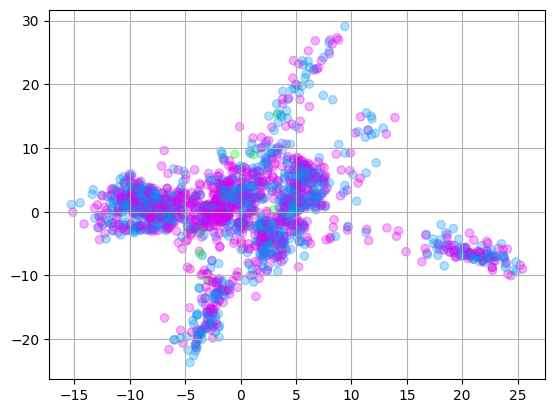

In [64]:
plt_embed = nlpsig.PlotEmbedding(x_data = x_data,
                                 y_data = dataset.df["label"].values)
plt_embed.plt_2d(
    embed_args = {
        "method": "pca",
        "dim": 2
    }
)

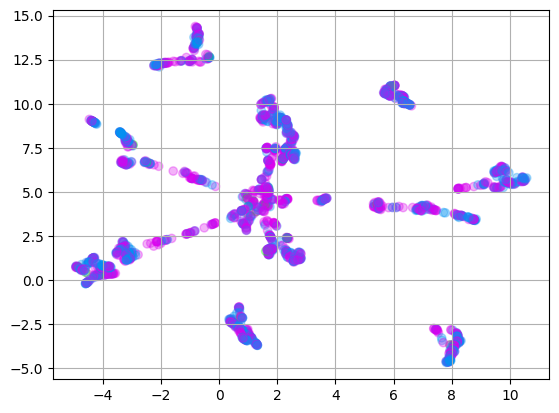

In [65]:
plt_embed.plt_2d(
    embed_args = {
        "method": "umap",
        "dim": 3
    }
)

## Training a FFN for classification

First we set some parameters for this specific example:

3

In [66]:
input_dim = x_data.shape[1]
hidden_dim = 200 #200
output_dim = len(dataset_df["label"].value_counts())
dropout_rate = 0.35 #0.35 #higher dropout than 0.25 and specifically 0.35 is very promising
num_epochs = 100
learning_rate = 0.0003 #0.0003 #empirically optimal lr value: 0.0001
gamma = 2 #3 #empirically optimal gamma value: 3
BATCH_SIZE = 64
NUM_folds = 5
patience = 2
weight_decay_adam = 0.0001

### KFold (splitting by groups)

The `GroupFolds` class in `nlpsig` splits the data in folds which can be used later on for K-Fold validation. We can pass in the groups into the initialisation of the object as follows:

In [67]:
data_folds = nlpsig.GroupFolds(df = dataset.df,
                               x_data = x_data,
                               y_data = torch.tensor(dataset.df["label"]),
                               groups = dataset.df["timeline_id"],
                               n_splits = NUM_folds)

By default, the class uses the [`GroupKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html) class from [scikit-learn](https://scikit-learn.org/stable/). This ensures that each group will appear exactly once in the test set across all folds, but it does not allow for shuffling the dataset.

If you'd like to shuffle the dataset, you can set `shuffle = True` (remember to set a seed number in `random_state` - but even if you don't, this defaults to `42`). In this case, the class uses [`GroupShuffleSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html). This *does not* ensure that each group will appear at least once in a test set. So in this choice, it is possible that some groups are never used to test in the K-Fold evalatuion.

In [68]:
data_folds_shuffled = nlpsig.GroupFolds(df = dataset.df,
                                        x_data = x_data,
                                        y_data = torch.tensor(dataset.df["label"]),
                                        groups = dataset.df["timeline_id"],
                                        n_splits = NUM_folds,
                                        shuffle = True,
                                        random_state = 2022)

The indicies for each fold are saved in `fold_indices` attribute

In [69]:
data_folds.fold_indices[0]

(array([ 156,  157,  158, ..., 1997, 1998, 1999]),
 array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
          11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
          22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
          33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
          44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
          55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
          66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
          77,   78,   79,   80,   81,   82,   83,   84,   85,   86,   87,
          88,   89,   90,   91,   92,   93,   94,   95,   96,   97,   98,
          99,  100,  101,  102,  103,  104,  105,  106,  107,  108,  109,
         110,  111,  112,  113,  114,  115,  116,  117,  118,  119,  120,
         121,  122,  123,  124,  125,  126,  127,  128,  129,  130,  131,
         132,  133,  134,  135,  136,  137,  138,  139,  140,

We can obtain training dataset, validation dataset, test datasets via the `.get_splits()` method, which slices the data using the indicies stored in `fold_indices` for a given fold. For example, if we wanted training, validation, and test datasets for the first fold, we have:

In [70]:
data_folds.get_splits(0)

(tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00, -1.4375e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00, -1.4375e+00],
         [ 0.0000e+00, -6.1035e-01,  3.6097e+00,  ..., -7.4506e-09,
          -2.9802e-08, -1.4375e+00],
         ...,
         [ 0.0000e+00, -3.2641e-01,  2.6874e+00,  ...,  3.9495e+00,
          -3.8193e-01,  1.4488e+00],
         [ 0.0000e+00, -1.0982e+00, -1.0805e+00,  ...,  3.4475e+00,
          -2.0165e-01,  1.4488e+00],
         [ 0.0000e+00, -5.5399e-01,  5.0340e-02,  ...,  3.4143e+00,
          -4.4583e-02,  1.4488e+00]]),
 tensor([2, 0, 0, 0, 2, 1, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2,
         2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2,
         0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2,
         2, 2, 2, 2, 2, 2, 0, 

By default, these will be in torch Tensors, but if we wanted them in as torch `DataLoader` objects, we set `as_DataLoader = True`:

In [71]:
data_folds.get_splits(fold_index = 0,
                      as_DataLoader = True)

(<torch.utils.data.dataloader.DataLoader at 0x29d840520>,
 <torch.utils.data.dataloader.DataLoader at 0x2a6b81850>)

### Fitting a PyTorch model

There are `validation_pytorch`, `training_pytorch` and `testing_pytorch` functions which we can use to train our model. We will do this with the first fold given above:

In [72]:
train, valid, test = data_folds.get_splits(fold_index = 0,
                                           as_DataLoader = True)

`training_pytorch` does all the training (and uses the validation set and `validation_pytorch` to do so):

In [73]:
# initial model definitions
model = FeedforwardNeuralNetModel(input_dim,
                                  hidden_dim,
                                  output_dim,
                                  dropout_rate)
criterion = FocalLoss(gamma = gamma)
optimizer = torch.optim.Adam(model.parameters(),
                             lr = learning_rate,
                             weight_decay = weight_decay_adam)

In [74]:
trained_model = nlpsig.training_pytorch(model = model,
                                        train_loader = train,
                                        valid_loader = valid,
                                        criterion = criterion,
                                        optimizer = optimizer,
                                        num_epochs=1000,
                                        seed = 2022,
                                        verbose = True)

  0%|                                                                                                              | 0/1000 [00:00<?, ?it/s]

Epoch: 1/1000 || Item: 0/1111 || Loss: 1.6430288553237915


  0%|                                                                                                      | 1/1000 [00:01<18:19,  1.10s/it]

Epoch: 1/1000 || Item: 1000/1111 || Loss: 0.03744242340326309
--------------------------------------------------
##### Epoch: 1/1000 || Loss: 0.008848604746162891
--------------------------------------------------
Epoch: 1 || Loss: 0.2532393157577319 || Accuracy: 0.5364963412284851 || F1-score: 0.35888825330596585.


  2%|█▌                                                                                                   | 15/1000 [00:16<18:05,  1.10s/it]

Early stopping at epoch 16!


Lets see how well it performs on the test set:

In [75]:
predicted, labels = nlpsig.testing_pytorch(model = model,
                                           test_loader = test)

0    1131
2     845
1      24
Name: label, dtype: int64

In [76]:
print("accuracy: " + str(((predicted == labels).sum() / labels.size(0)).item()))

accuracy: 0.589442789554596


### KFold evaluation of a PyTorch model

We have created a function called `KFold_pytorch` which allows you to pass in a `GroupFolds` object (which stores the folds and data), a Pytorch model, loss function and optimizer in and will perform the K-Fold evaluation. This returns the accuracy and F1-scores of each fold as a dataframe.

We need to initialise the models first. It is vital that these are untrained, as we will do the K-Fold evaluation by first saving the PyTorch model and optimizer states. For each fold, these are re-loaded and then training and testing is performed for that particular fold.

In [77]:
# initial model definitions
model = FeedforwardNeuralNetModel(input_dim,
                                  hidden_dim,
                                  output_dim,
                                  dropout_rate)
criterion = FocalLoss(gamma = gamma)
optimizer = torch.optim.Adam(model.parameters(),
                             lr = learning_rate,
                             weight_decay = weight_decay_adam)

We simply pass this into `KFold_pytorch` function as follows:

In [78]:
kfold_eval = nlpsig.KFold_pytorch(data_folds,
                                  model = model,
                                  criterion = criterion,
                                  optimizer = optimizer,
                                  num_epochs = 1000,
                                  verbose_args = {
                                      "verbose": True,
                                      "verbose_epoch": 20,
                                      "verbose_item": 10000
                                  })

  0%|                                                                                                                 | 0/5 [00:00<?, ?it/s]/Users/rchan/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/rough_paths/path_signatures_bert/nlpsig/pytorch_utils.py:169: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  criterion.set_alpha_from_y(y = torch.tensor(y_train))



**************************************************
Fold: 1 / 5
**************************************************



  0%|                                                                                                              | 0/1000 [00:00<?, ?it/s]

Epoch: 1/1000 || Item: 0/1111 || Loss: 3.259897232055664



  0%|                                                                                                      | 1/1000 [00:01<19:08,  1.15s/it]

--------------------------------------------------
##### Epoch: 1/1000 || Loss: 0.44480225443840027
--------------------------------------------------
Epoch: 1 || Loss: 0.6871108186140615 || Accuracy: 0.5091241002082825 || F1-score: 0.33810470330445636.



  2%|██                                                                                                   | 20/1000 [00:22<17:47,  1.09s/it]

Epoch: 21/1000 || Item: 0/1111 || Loss: 0.2449704259634018



  2%|██                                                                                                   | 21/1000 [00:23<17:54,  1.10s/it]

--------------------------------------------------
##### Epoch: 21/1000 || Loss: 0.19298487901687622
--------------------------------------------------
Epoch: 21 || Loss: 3.0515410575994224 || Accuracy: 0.4781021773815155 || F1-score: 0.277788275520763.



  4%|████                                                                                                 | 40/1000 [00:44<17:34,  1.10s/it]

Epoch: 41/1000 || Item: 0/1111 || Loss: 0.3643237054347992



  4%|████▏                                                                                                | 41/1000 [00:45<17:30,  1.10s/it]

--------------------------------------------------
##### Epoch: 41/1000 || Loss: 0.0011263604974374175
--------------------------------------------------
Epoch: 41 || Loss: 10.590729098710224 || Accuracy: 0.49635037779808044 || F1-score: 0.27876452189454876.



 20%|█████████████████████                                                                                    | 1/5 [00:48<03:12, 48.05s/it]/Users/rchan/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/rough_paths/path_signatures_bert/nlpsig/pytorch_utils.py:169: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  criterion.set_alpha_from_y(y = torch.tensor(y_train))


Early stopping at epoch 43!

**************************************************
Fold: 2 / 5
**************************************************



  0%|                                                                                                              | 0/1000 [00:00<?, ?it/s]

Epoch: 1/1000 || Item: 0/1012 || Loss: 0.009128635749220848



  0%|                                                                                                      | 1/1000 [00:01<18:12,  1.09s/it]

--------------------------------------------------
##### Epoch: 1/1000 || Loss: 0.4454842209815979
--------------------------------------------------
Epoch: 1 || Loss: 0.7218885194465063 || Accuracy: 0.5210421085357666 || F1-score: 0.30225017470300486.



  2%|██                                                                                                   | 20/1000 [00:20<16:09,  1.01it/s]

Epoch: 21/1000 || Item: 0/1012 || Loss: 0.08616822957992554



  2%|██                                                                                                   | 21/1000 [00:21<16:05,  1.01it/s]

--------------------------------------------------
##### Epoch: 21/1000 || Loss: 0.06480317562818527
--------------------------------------------------
Epoch: 21 || Loss: 2.4058185239132777 || Accuracy: 0.531062126159668 || F1-score: 0.31906969815466546.



 40%|██████████████████████████████████████████                                                               | 2/5 [01:14<01:46, 35.46s/it]/Users/rchan/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/rough_paths/path_signatures_bert/nlpsig/pytorch_utils.py:169: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  criterion.set_alpha_from_y(y = torch.tensor(y_train))


Early stopping at epoch 26!

**************************************************
Fold: 3 / 5
**************************************************



  0%|                                                                                                              | 0/1000 [00:00<?, ?it/s]

Epoch: 1/1000 || Item: 0/1108 || Loss: 0.15960434079170227



  0%|                                                                                                      | 1/1000 [00:01<20:05,  1.21s/it]

--------------------------------------------------
##### Epoch: 1/1000 || Loss: 0.06098439171910286
--------------------------------------------------
Epoch: 1 || Loss: 0.7103022122636247 || Accuracy: 0.5494505763053894 || F1-score: 0.3013465077981207.



 60%|███████████████████████████████████████████████████████████████                                          | 3/5 [01:21<00:44, 22.41s/it]/Users/rchan/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/rough_paths/path_signatures_bert/nlpsig/pytorch_utils.py:169: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  criterion.set_alpha_from_y(y = torch.tensor(y_train))


Early stopping at epoch 6!

**************************************************
Fold: 4 / 5
**************************************************



  0%|                                                                                                              | 0/1000 [00:00<?, ?it/s]

Epoch: 1/1000 || Item: 0/1015 || Loss: 1.9513946771621704



  0%|                                                                                                      | 1/1000 [00:01<17:29,  1.05s/it]

--------------------------------------------------
##### Epoch: 1/1000 || Loss: 0.5094991326332092
--------------------------------------------------
Epoch: 1 || Loss: 0.506091718392785 || Accuracy: 0.5349301099777222 || F1-score: 0.334828617437313.



 80%|████████████████████████████████████████████████████████████████████████████████████                     | 4/5 [01:36<00:19, 19.30s/it]/Users/rchan/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/rough_paths/path_signatures_bert/nlpsig/pytorch_utils.py:169: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  criterion.set_alpha_from_y(y = torch.tensor(y_train))


Early stopping at epoch 14!

**************************************************
Fold: 5 / 5
**************************************************



  0%|                                                                                                              | 0/1000 [00:00<?, ?it/s]

Epoch: 1/1000 || Item: 0/1112 || Loss: 0.40888288617134094



  0%|                                                                                                      | 1/1000 [00:01<17:51,  1.07s/it]

--------------------------------------------------
##### Epoch: 1/1000 || Loss: 0.2512040436267853
--------------------------------------------------
Epoch: 1 || Loss: 0.6673784349201864 || Accuracy: 0.49817517399787903 || F1-score: 0.31896289298273234.



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:50<00:00, 22.03s/it]

Early stopping at epoch 13!


The accuracy and F1-scores are then saved as follows:

In [80]:
kfold_eval

accuracy  f1_score
0  0.551320  0.289791
1  0.548057  0.354283
2  0.404624  0.230287
3  0.491736  0.317590
4  0.514706  0.336506